# Pypi network evolution

##### Setup olivia

In [1]:
# Olivia Finder requirements
%pip install -r ../olivia/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
from time import time
import networkx as nx
import psutil



#### **Utilities**

In [3]:

def add_chunk(
    df, G, dependent_field, dependency_field,
    filter_field=None,
    filter_value=None
):
    """ Utility method for build_dependency_network"""
    filtered = df[df[filter_field] == filter_value] if filter_field else df
    links = list(zip(filtered[dependency_field], filtered[dependent_field]))
    G.add_edges_from(links)
    return G

def build_dependency_network(
    df,
    chunk_size,
    dependent_field: str = 'Project Name',
    dependency_field: str = 'Dependency Name',
    filter_field=None,
    filter_value=None,
    verbose: bool = True
):
    # Print only if verbose
    vprint = print if verbose else lambda *a, **k: None
    process = psutil.Process(os.getpid())
    vprint("Using process ", process)
    t = time()
    try:
        vprint('Initializing graph... ', end='')
        # New NetworkX directed Graph
        G = nx.DiGraph()
        vprint('OK')
        
        # Split DataFrame into chunks
        chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
        
        for i, chunk in enumerate(chunks):
            # Add dependencies from chunk to G
            add_chunk(
                chunk, 
                G,
                dependent_field=dependent_field,
                dependency_field=dependency_field,
                filter_field=filter_field,
                filter_value=filter_value
            )
            vprint(f'{round(i*chunk_size/1e6,1)}M lines | {len(G)} nodes, {len(G.edges)} deps. ({int(time()-t)}s) {round(process.memory_info().rss/1e6,1)}Mb')
        vprint('Done processing DataFrame')
        
        # IMPORTANT: Reverse the graph to get the correct dependencies
        return G.reverse(copy=True)
    
    except Exception as e:
        print('\n', e)

def plot_degree_distribution(G, title, color):
    '''
    Plot the degree distribution of a networkx graph
    '''

    # Nodes' degree vector
    degree=[x[1] for x in G.degree()]
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    # Plot histogram without log scale
    axs[0].hist(degree, color=color)
    axs[0].set_title(title)
    axs[0].set_xlabel('Degree')
    axs[0].set_ylabel('Number of nodes')
    
    # Plot histogram with log scale
    axs[1].hist(degree, bins=100, color=color)
    axs[1].set_title(f"{title} in log scale")
    axs[1].set_xlabel('Degree')
    axs[1].set_ylabel('Number of nodes')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    
    plt.show()

def draw_networkx_graph(G, layout='circular', size=(20,20)):
    '''
    Draw a networkx graph
    '''

    layouts = {
        'circular': nx.circular_layout,
        'kamada_kawai': nx.kamada_kawai_layout,
        'random': nx.random_layout,
        'shell': nx.shell_layout,
        'spring': nx.spring_layout,
        'spectral': nx.spectral_layout,
        'random': nx.random_layout,
    }
    plt.figure(figsize=size)
    pos = layouts[layout](G)
    node_size = [G.in_degree(node) * 80 for node in G]
    node_color = [G.in_degree(node) for node in G]
    edge_color = 'black'
    width = 1
    nx.draw_networkx(G, pos=pos, node_size=node_size, node_color=node_color, alpha=0.7,
                     with_labels=False, edge_color=edge_color, width=width)
    
    # Agregar etiquetas personalizadas
    labels = {node: node for node in G.nodes()}
    node_labels = nx.draw_networkx_labels(G, pos=pos, labels=labels, font_size=8,
                                          font_weight='bold', bbox=dict(facecolor='red', edgecolor='none', pad=0.3))

    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()


def draw_package_deep_network(G, package_name, deep, size=(10, 10), layout='spring', title=None):
    '''
    Draw the subgraph of a package and its dependencies up to a certain depth.

    '''

    layouts = {
        'circular': nx.circular_layout,
        'kamada_kawai': nx.kamada_kawai_layout,
        'random': nx.random_layout,
        'shell': nx.shell_layout,
        'spring': nx.spring_layout,
        'spectral': nx.spectral_layout,
    }

    # Create a subgraph of the package and its dependencies up to a certain depth
    # subgraph = nx.ego_graph(G, package_name, radius=deep, center=True)
    subgraph = nx.ego_graph(G, package_name, radius=deep, center=True)

    # Draw the subgraph
    plt.figure(figsize=size)
    pos = layouts[layout](subgraph)
    node_size = [subgraph.in_degree(node) * 100 for node in subgraph]
    node_color = [subgraph.in_degree(node) for node in subgraph]
    edge_color = 'black'
    width = 1
    nx.draw_networkx(subgraph, pos=pos, node_size=node_size, node_color=node_color, alpha=0.7,
                        with_labels=False, edge_color=edge_color, width=width)
    
    # Add title
    if title:
        plt.title(title, fontsize=16, fontweight='bold')


    # Set target node square in blue
    nx.draw_networkx_nodes(subgraph, pos=pos, nodelist=[package_name], node_size=100, node_color='blue', alpha=0.7)

    # Add custom labels
    labels = {node: node for node in subgraph.nodes()}
    nx.draw_networkx_labels(
        subgraph, pos=pos, labels=labels, font_size=8,
        font_weight='bold', bbox=dict(facecolor='red', edgecolor='none', pad=0.3)
    )
    
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()

    return subgraph

def plot_comparation(m1, m2, t_m1, t_m2, offset=0):
    plt.figure(figsize=(15, 3))
    
    # Gráfico para libraries.io
    plt.subplot(1, 2, 1)
    plt.bar([x[0] for x in m1], [x[1] for x in m1], color='orange')
    plt.xticks(rotation=90)
    plt.title(t_m1, fontsize=14, fontweight='bold')
    plt.ylabel(t_m1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='x', labelsize=12)
    plt.gca().tick_params(axis='y', labelsize=12)
    bar_size = [x[1] for x in m1]
    for i in range(len(m1)):
        plt.text(i, bar_size[i] + offset , str(bar_size[i]), ha='center', va='center', color='black')

    # Gráfico para Scraped Packages
    plt.subplot(1, 2, 2)
    plt.bar([x[0] for x in m2], [x[1] for x in m2], color='purple')
    plt.xticks(rotation=90)
    plt.title(t_m2, fontsize=14, fontweight='bold')
    plt.ylabel(t_m2)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='x', labelsize=12)
    plt.gca().tick_params(axis='y', labelsize=12)
    bar_size = [x[1] for x in m2]
    for i in range(len(m2)):
        plt.text(i, bar_size[i] + offset, str(bar_size[i]), ha='center', va='center', color='white')

    plt.show()

def plot_bar_chart(m1, m2, tit, offset = 1000):
    # Configuring colors
    colors = ['orange', 'purple']

    # Heights of the bars
    height_libio = [node[1] for node in m1]
    height_scraped = [node[1] for node in m2]

    # Create the bar plot (one bar next to each other)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(np.arange(len(m1)), height_libio, color=colors[0], width=0.4)
    ax.bar(np.arange(len(m2)) + 0.4, height_scraped, color=colors[1], width=0.4)

    # Configure xticks orientation and position
    ax.set_xticks(np.arange(len(m1)) + 0.2)
    ax.set_xticklabels([node[0] for node in m1], rotation=45, ha='right', fontsize=8)

    # Configure titles and axis labels
    ax.set_title(tit, fontsize=20, fontweight='bold')
    ax.set_xlabel('Package')
    ax.set_ylabel('In degree')

    # Add labels to the sections of the bar chart
    for i, v in enumerate(height_libio):
        ax.text(i, v + offset, str(v), ha='center', va='center', color='black', rotation=90)
    for i, v in enumerate(height_scraped):
        ax.text(i + 0.4, v + offset, str(v), ha='center', va='center', color='black', rotation=90)

    # Add a horizontal grid
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjusting plot borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjusting tick labels font size
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # Configure legend
    legend_labels = ['librariesio', 'scraped']
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
    ax.legend(legend_handles, legend_labels)

    # Show the bar plot
    plt.show()

def calculate_metrics(G):
    '''
    Calculates the following metrics for a given graph:
    - Number of nodes
    - Number of edges
    - Average clustering coefficient
    - Average shortest path length
    - Number of connected components
    - Diameter
    - Average degree
    - Average in degree
    - Average out degree
    - Number of self-loops
    - Number of isolated nodes
    '''
    
    return pd.DataFrame(
        {
            'Number of nodes': [G.number_of_nodes()],
            'Number of edges': [G.number_of_edges()],
            'Average clustering coefficient': [nx.average_clustering(G)],
            'Average degree': [sum(dict(G.degree()).values())/G.number_of_nodes()],
            'Average in degree': [sum(dict(G.in_degree()).values())/G.number_of_nodes()],
            'Average out degree': [sum(dict(G.out_degree()).values())/G.number_of_nodes()],
            'Number of isolated nodes': [len(list(nx.isolates(G)))]
        }
    )

def plot_dict(d, title, xlabel, ylabel, rotation=90, size=(15, 3), 
              offset=100, label_size=12, label_rotation=0, font_size=14, color='orange', tit_pad=20, w=0.4):
    '''
    Plots a dictionary as a bar chart.
    '''

    plt.figure(figsize=size)
    plt.bar(d.keys(), d.values(), color=color, width=w)
    plt.xticks(rotation=label_rotation)
    plt.title(title, fontsize=font_size, fontweight='bold', pad=tit_pad)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='x', labelsize=label_size)
    plt.gca().tick_params(axis='y', labelsize=label_size)
    bar_size = [x[1] for x in d.items()]
    for i in range(len(d)):
        plt.text(i, bar_size[i] + offset, str(bar_size[i]), ha='center', va='center', color='black', rotation=rotation)

    plt.show()



## 1 - Data processing

### Librariesio network data analysis

**1 - Visualization of librariesio DataSet**

In [4]:
# Load librariesio csv file
librariesio_df = pd.read_csv('../results/csv_datasets/pypi/pypi_adjlist_librariesio.csv')

# Remove not necessary columns
librariesio_df = librariesio_df.drop(
    columns=[
        'ID', 
        'Platform', 
        'Project ID', 
        'Version ID', 
        'Dependency Platform', 
        'Optional Dependency', 
        'Dependency Requirements', 
        'Dependency Project ID'
    ]
)

# Saw number of rows and columns
initial_rows = librariesio_df.shape[0]
print("Dataframe shape: ", librariesio_df.shape)
librariesio_df.head(10)

Dataframe shape:  (2018342, 4)


Project Name Version Number Dependency Name Dependency Kind
0        1pass          0.1.2   simple-pbkdf2         runtime
1        1pass          0.1.2        pycrypto         runtime
2        1pass          0.1.3   simple-pbkdf2         runtime
3        1pass          0.1.3        PyCrypto         runtime
4        1pass          0.1.5   simple-pbkdf2         runtime
5        1pass          0.1.5        PyCrypto         runtime
6        1pass          0.1.6   simple-pbkdf2         runtime
7        1pass          0.1.6        PyCrypto         runtime
8        1pass          0.1.7   simple-pbkdf2         runtime
9        1pass          0.1.7        PyCrypto         runtime

**2 - Collection of versions for the same package**

One of the things we notice is that there are data entries for different versions of the same package. Let's show an example.

In [5]:
# Sow nmfem package
librariesio_df[librariesio_df['Project Name'] == '1pass']

Project Name Version Number Dependency Name Dependency Kind
0         1pass          0.1.2   simple-pbkdf2         runtime
1         1pass          0.1.2        pycrypto         runtime
2         1pass          0.1.3   simple-pbkdf2         runtime
3         1pass          0.1.3        PyCrypto         runtime
4         1pass          0.1.5   simple-pbkdf2         runtime
5         1pass          0.1.5        PyCrypto         runtime
6         1pass          0.1.6   simple-pbkdf2         runtime
7         1pass          0.1.6        PyCrypto         runtime
8         1pass          0.1.7   simple-pbkdf2         runtime
9         1pass          0.1.7        PyCrypto         runtime
10        1pass          0.1.8   simple-pbkdf2         runtime
11        1pass          0.1.8        PyCrypto         runtime
12        1pass          0.2.0   simple-pbkdf2         runtime
13        1pass          0.2.0        PyCrypto         runtime
14        1pass          0.2.0      fuzzywuzzy         runtime
15        1pass          0.2.1        M2Crypto         runtime
16        1pass          0.2.1      fuzzywuzzy         runtime

To solve this issue, we will only consider the most recent version of the package.

Let's observe the format that these version numbers take:

In [6]:
# Show librariesio_df dataframe unique values at column 'Version Number'
print("Unique values at column 'Version Number': ", librariesio_df['Version Number'].unique())
print("Total:",len(librariesio_df['Version Number'].unique()))

Unique values at column 'Version Number':  ['0.1.2' '0.1.3' '0.1.5' ... '2020.0.7' '2020.0.8' '2020.0.9']
Total: 57961


Assuming that the dataset is sorted with packages in ascending order of version, we generate a package-version dictionary that associates each package with the latest updated version.

In [7]:
package_version = {}

# Loop all the rows
for index, row in tqdm.tqdm(librariesio_df.iterrows(), total=librariesio_df.shape[0]):
    # Get the version number
    version_number = row['Version Number']
    # Get the project name
    project_name = row['Project Name']

    if project_name not in package_version:
        package_version[project_name] = version_number
    else:
        if version_number != package_version[project_name]:
            package_version[project_name] = version_number


  0%|          | 0/2018342 [00:00<?, ?it/s]

100%|██████████| 2018342/2018342 [02:23<00:00, 14052.97it/s]


In [9]:
# Show the dictionary
package_version["1pass"]

'0.2.1'

In [8]:
# Identify the rows to keep
mask = librariesio_df['Version Number'] == librariesio_df['Project Name'].map(package_version)

# Filter the dataframe
librariesio_df = librariesio_df[mask]

The result is a filtered dataset, removing package duplicity for different version numbers.

In [9]:
# Sow nmfem package
librariesio_df[librariesio_df['Project Name'] == '1pass']

Project Name Version Number Dependency Name Dependency Kind
15        1pass          0.2.1        M2Crypto         runtime
16        1pass          0.2.1      fuzzywuzzy         runtime

In total, the data processing yields the following statistics:

In [10]:
final_rows = librariesio_df.shape[0]

print("Initial rows: ", initial_rows)
print("Final rows: ", final_rows)
print("Rows removed: ", initial_rows - final_rows)

Initial rows:  2018342
Final rows:  134829
Rows removed:  1883513


**3 - Librariesio "Dependency Kind" field**

As you can see, the libraries.io dataset includes a lot of irrelevant information. That's why we're going to clean it up to get a better visualization of the data.

One of the first things we notice is the "Dependency Kind" field. This field indicates the type of dependency that a particular package is. This classification is specific to the R programming language.

There are different types:


In [11]:
# Obtener los distintos tipos de "Dependency Kind"
librariesio_df['Dependency Kind'].unique().tolist()

['runtime']

In [12]:
# Export the dataframe to csv
librariesio_df.to_csv('../results/csv_datasets/pypi/pypi_adjlist_librariesio_filtered.csv', index=False)

In [13]:
librariesio_df.head()

Project Name Version Number Dependency Name Dependency Kind
15        1pass          0.2.1        M2Crypto         runtime
16        1pass          0.2.1      fuzzywuzzy         runtime
27         2mp4          0.2.1              sh         runtime
28         2mp4          0.2.1    progressbar2         runtime
29         2mp4          0.2.1     pymediainfo         runtime

### Scraped network data analysis

**1 - Visualization of scraped dataset**

In [4]:
scraped_df = pd.read_csv('../olivia_finder/results/csv_datasets/pypi/pypi_adjlist_scraping.csv')
# Remove colunmn version
scraped_df = scraped_df.drop(columns=['version', 'url', 'dependency_version', 'dependency_url'])
print(scraped_df.shape)
scraped_df.head()


(933955, 2)


name dependency
0  0x-sra-client    urllib3
1  0x-sra-client        six
2  0x-sra-client    certifi
3  0x-sra-client     python
4  0x-sra-client         0x

As can be observed, this dataset contains 197460 distinct packages.

In [7]:
# Number of rows with unique name values
print("Unique values at column 'name': ", len(scraped_df['name'].unique()))

Unique values at column 'name':  197460


## 2 - Comparation

### **Packages evolution**

By comparing the packages present in the different generated networks, we conclude that CRAN has been growing during this period of time (approximately 16%), and one-third of the existing packages have been replaced by others.

In [8]:
libraiesio_packages = librariesio_df['Project Name'].unique().tolist()
scraping_packages = scraped_df['name'].unique().tolist()
common_packages = list(set(libraiesio_packages) & set(scraping_packages))

print ("Packages in librariesio: ", len(libraiesio_packages))
print ("Packages in scraped: ", len(scraping_packages))
print ("Common packages: ", len(common_packages))
print("Packages in librariesio that are not in scraped: ", len(list(set(libraiesio_packages) - set(scraping_packages))))
print("Packages in scraped that are not in librariesio: ", len(list(set(scraping_packages) - set(libraiesio_packages))))

Packages in librariesio:  41621
Packages in scraped:  197460
Common packages:  24001
Packages in librariesio that are not in scraped:  17620
Packages in scraped that are not in librariesio:  173459


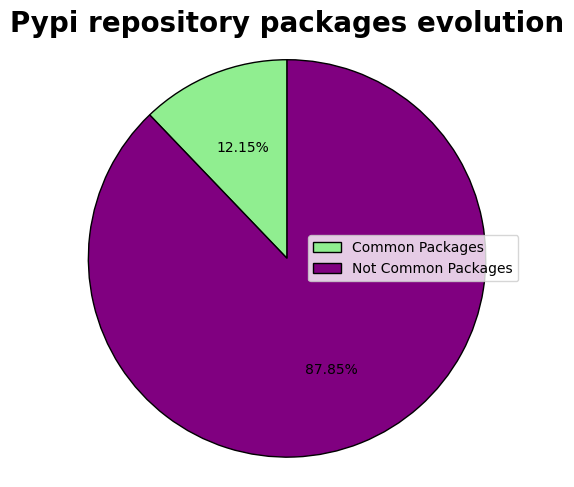

In [8]:
# Data for the graph
labels = ['Common Packages', 'Not Common Packages']
colors = ['lightgreen', 'purple']
sizes = [len(common_packages), len(list(set(scraping_packages) - set(libraiesio_packages)))]

# Customize the graph
fig, ax = plt.subplots()
ax.pie(sizes, autopct='%1.2f%%', startangle=90, colors=colors)
ax.set_aspect('equal')
ax.set_title('Pypi repository packages evolution', fontsize=20, fontweight='bold')

# add a black border to the pie

for pie_wedge in ax.patches:
    pie_wedge.set_edgecolor('black')

# Add legend
ax.legend(labels, loc='best')

# Improve aesthetics
plt.axis('equal')
plt.tight_layout()
# size of the figure
fig.set_size_inches(5, 5)

# Display the graph
plt.show()

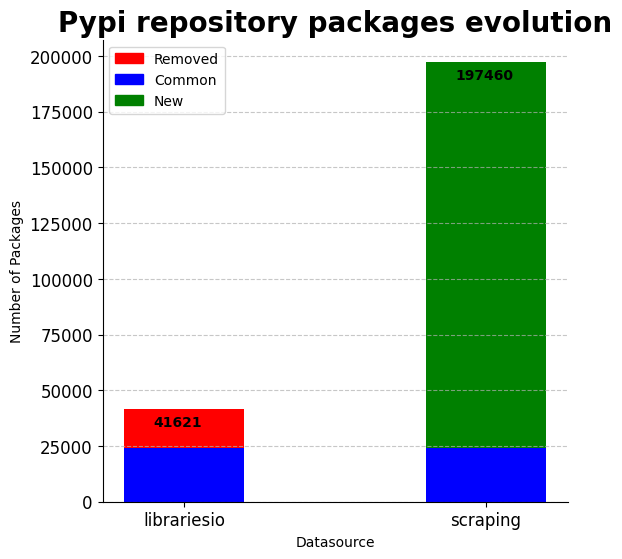

In [10]:
# Identifying common packages, exclusive to lista1, and exclusive to lista2
common_packages = list(set(libraiesio_packages) & set(scraping_packages))
new_packages = list(set(scraping_packages) - set(libraiesio_packages))
old_packages = list(set(libraiesio_packages) - set(scraping_packages))

# Configuring colors
colors_lista1 = ['red', 'blue']
colors_lista2 = ['green', 'blue']

# Heights of the bars
height_lista1 = len(libraiesio_packages)
height_lista2 = len(scraping_packages)

# Create the bar plot
fig, ax = plt.subplots(figsize=(6, 6))

# Bar for lista1
ax.bar('librariesio', height_lista1, color=colors_lista1, width=0.4)
ax.bar('librariesio', len(old_packages), color='red', width=0.4,)
ax.bar('librariesio', len(common_packages), color='blue', width=0.4)

# Bar for lista2
ax.bar('scraping', height_lista2, color=colors_lista2, width=0.4)
ax.bar('scraping', len(new_packages), color='green', width=0.4)
ax.bar('scraping', len(common_packages), color='blue', width=0.4)

# Configure titles and axis labels
ax.set_title('Pypi repository packages evolution', fontsize=20, fontweight='bold')
ax.set_xlabel('Datasource')
ax.set_ylabel('Number of Packages')

# Add labels to the sections of the bar chart
ax.text(-0.1, height_lista1 - 8000, str(height_lista1), color='black', fontweight='bold')
ax.text(0.9, height_lista2 - 8000, str(height_lista2), color='black', fontweight='bold')

# Add a horizontal grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjusting plot borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjusting tick labels font size
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Configure legend
legend_labels = ['Removed', 'Common', 'New']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors_lista1 + ['green']]
ax.legend(legend_handles, legend_labels)

# Show the bar plot
plt.show()


### **Network analysis**

We construct the networks to perform the analysis, using a directed network (A --> B, where B is a direct dependency of A).

In [5]:
# Libraries.io graph
librariesio_G = build_dependency_network(
    df = librariesio_df,
    chunk_size = 100000,
    dependent_field = 'Project Name',
    dependency_field = 'Dependency Name',
)

# Scraped graph
scraped_G = build_dependency_network(
    df = scraped_df,
    chunk_size = 100000,
    dependent_field = 'name',
    dependency_field = 'dependency',
)

Using process  psutil.Process(pid=18767, name='python', status='running', started='16:16:06')
Initializing graph... OK
0.0M lines | 36460 nodes, 99878 deps. (0s) 235.7Mb
0.1M lines | 49306 nodes, 134575 deps. (0s) 254.7Mb
Done processing DataFrame
Using process  psutil.Process(pid=18767, name='python', status='running', started='16:16:06')
Initializing graph... OK
0.0M lines | 27862 nodes, 100000 deps. (0s) 315.8Mb
0.1M lines | 50691 nodes, 200000 deps. (0s) 365.1Mb
0.2M lines | 74430 nodes, 300000 deps. (0s) 409.7Mb
0.3M lines | 95992 nodes, 400000 deps. (0s) 463.5Mb
0.4M lines | 116076 nodes, 500000 deps. (1s) 507.0Mb
0.5M lines | 146334 nodes, 600000 deps. (1s) 559.2Mb
0.6M lines | 168073 nodes, 700000 deps. (1s) 605.3Mb
0.7M lines | 187955 nodes, 800000 deps. (2s) 666.3Mb
0.8M lines | 207589 nodes, 900000 deps. (2s) 709.5Mb
0.9M lines | 214470 nodes, 933955 deps. (2s) 719.5Mb
Done processing DataFrame


#### **1 - Degree**

Regarding the degree distribution, no significant changes are observed.

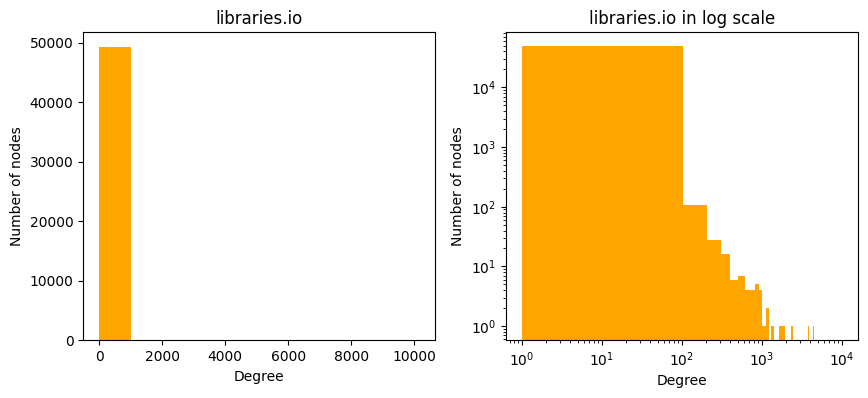

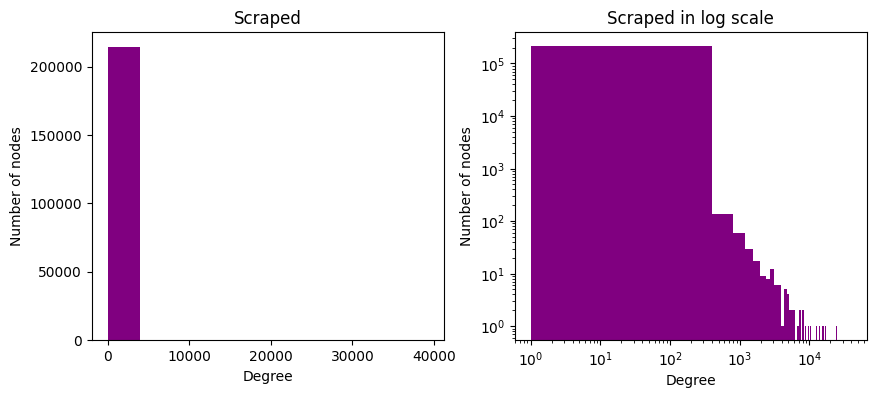

In [10]:
plot_degree_distribution(librariesio_G, 'libraries.io', "orange")
plot_degree_distribution(scraped_G, 'Scraped', "purple")

It can indeed be observed that there has been an increase in the average degree of the network during this evolution.

In [11]:
# Libraries.io graph average degree
print("Average degree of libraries.io graph: ", librariesio_G.number_of_edges() / librariesio_G.number_of_nodes())
# Scraped graph average degree
print("Average degree of scraped graph: ", scraped_G.number_of_edges() / scraped_G.number_of_nodes())



Average degree of libraries.io graph:  2.729383847807569
Average degree of scraped graph:  4.354711614678044


#### **2 - Out degree**

##### Evolution

Top out degree librariesio packages evolution

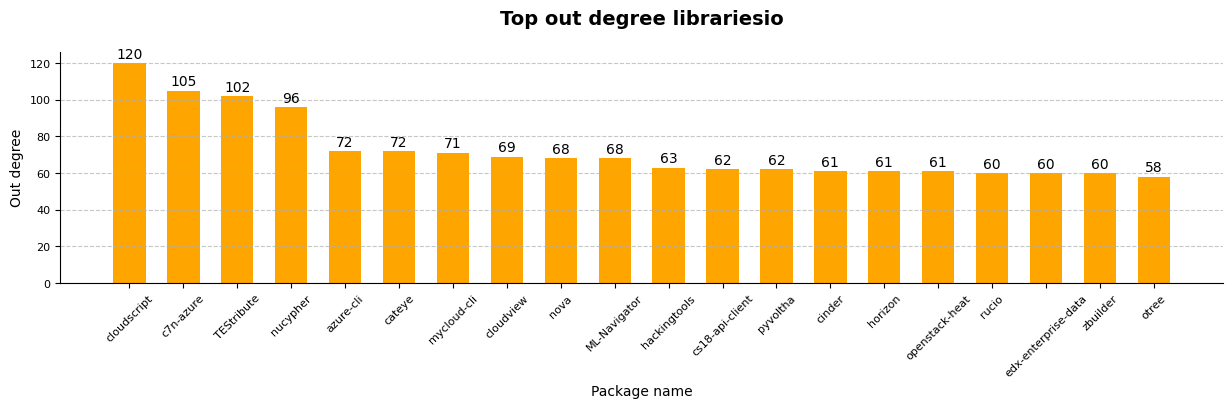

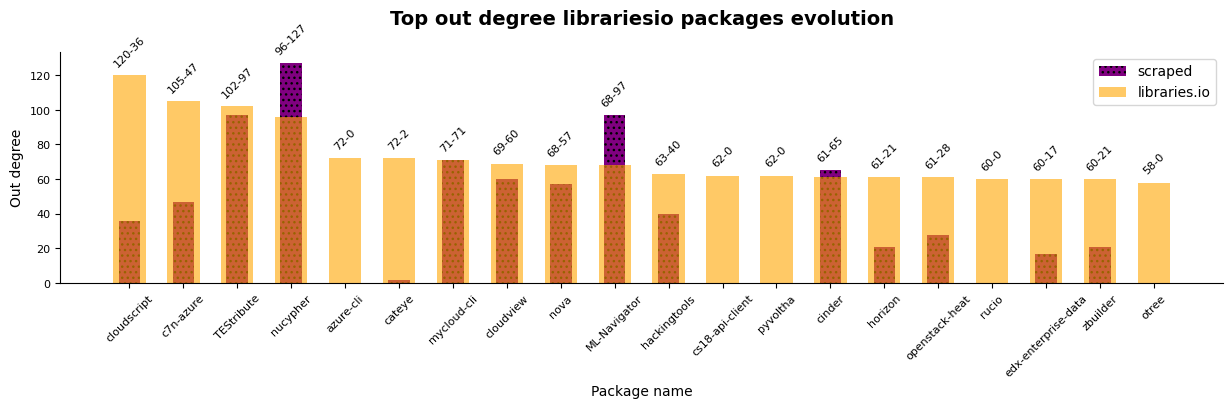

In [12]:
libio_t20_outd = sorted(librariesio_G.out_degree(), key=lambda x: x[1], reverse=True)[:20]

plot_dict(
    d = dict(libio_t20_outd),
    title = 'Top out degree librariesio',
    xlabel = 'Package name',
    ylabel = 'Out degree',
    rotation = 0,
    size = (15, 3),
    offset = 5,
    label_size = 8,
    font_size = 14,
    label_rotation = 45,
    w=0.6
)

# Plot evolution of top (librariesio) out degree
# ------------------------------------------------

scraped_libio_t20_comparation = []
for node in libio_t20_outd:
    if node[0] in scraped_G.nodes():
        scraped_libio_t20_comparation.append((node[0], scraped_G.out_degree(node[0])))
    else:
        scraped_libio_t20_comparation.append((node[0], 0))

# Plot comparison
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in scraped_libio_t20_comparation],
    [x[1] for x in scraped_libio_t20_comparation],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='...',

)

plt.bar(
    [x[0] for x in libio_t20_outd],
    [x[1] for x in libio_t20_outd],
    label='libraries.io',
    color='orange',
    width=0.6,
    alpha=0.6,
)

for i, v, i2, v2 in zip( [x[0] for x in libio_t20_outd], [x[1] for x in libio_t20_outd], [x[0] for x in scraped_libio_t20_comparation], [x[1] for x in scraped_libio_t20_comparation]):
    plt.text(i, max(v,v2)+5, f'{v}-{v2}', color='black', ha='center', rotation=45, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)

plt.title('Top out degree librariesio packages evolution', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Package name')
plt.ylabel('Out degree')
plt.xticks(rotation=45)
plt.legend()

plt.show()

Top out degree scraped packages evolution

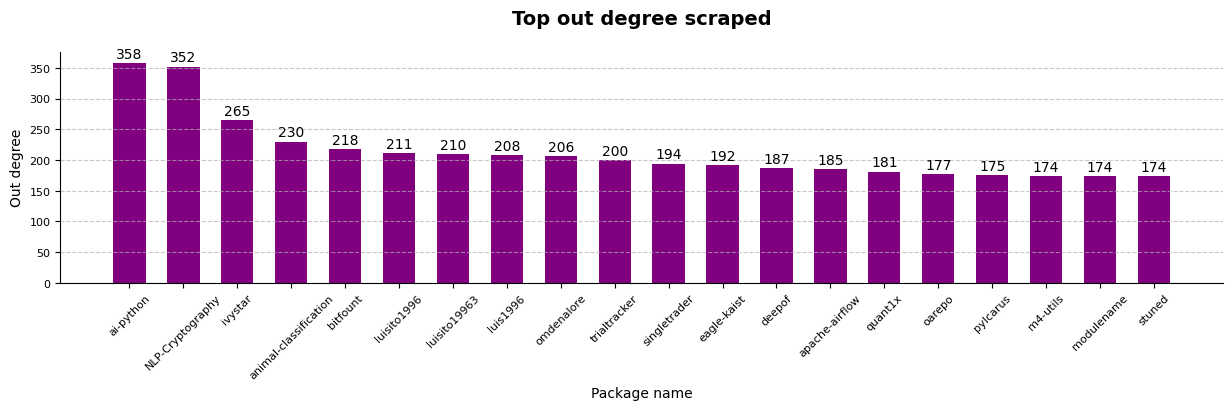

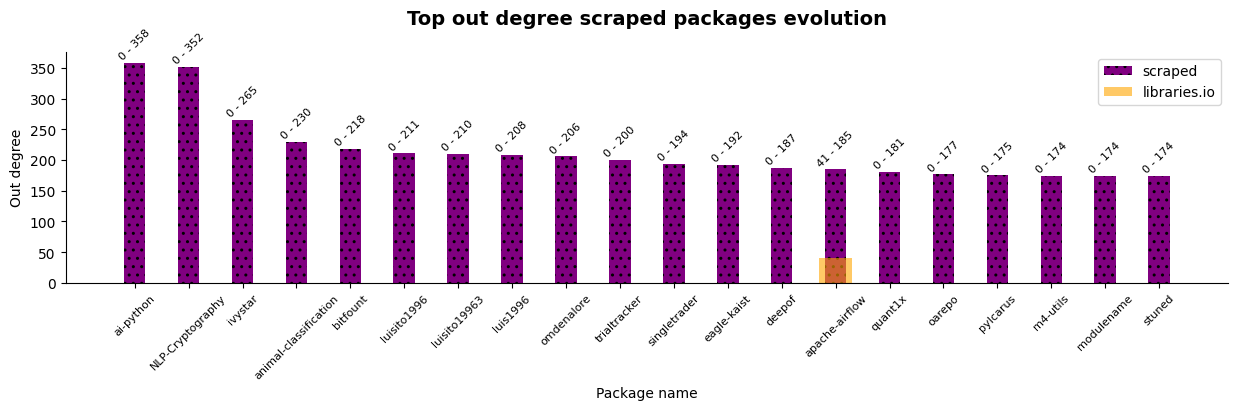

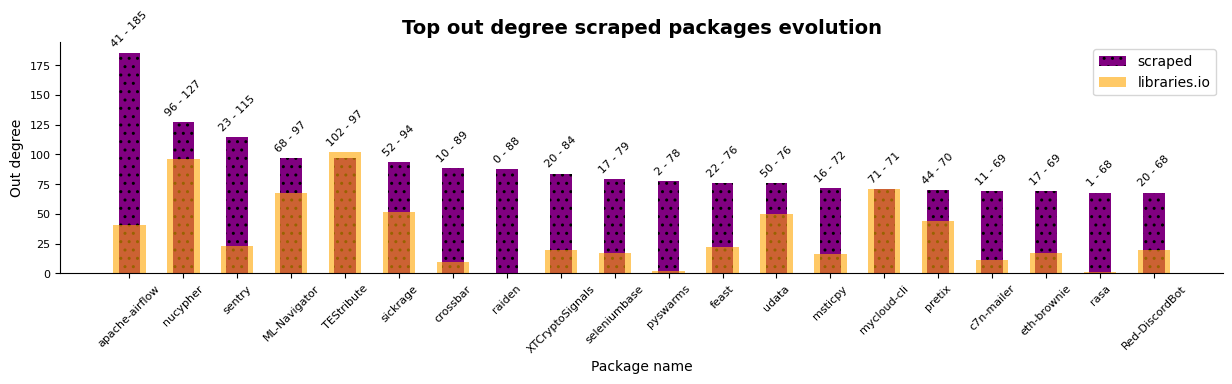

In [13]:
scraped_t20_outd = sorted(scraped_G.out_degree(), key=lambda x: x[1], reverse=True)[:20]

plot_dict(
    d = dict(scraped_t20_outd),
    title = 'Top out degree scraped',
    xlabel = 'Package name',
    ylabel = 'Out degree',
    rotation = 0,
    size = (15, 3),
    offset = 15,
    label_size = 8,
    font_size = 14,
    label_rotation = 45,
    color = 'purple',
    w=0.6
)


# Plot evolution of top (librariesio) out degree
# ------------------------------------------------

libio_scraped_t20_comparation = []
for node in scraped_t20_outd:
    if node[0] in librariesio_G.nodes():
        libio_scraped_t20_comparation.append((node[0], librariesio_G.out_degree(node[0])))
    else:
        libio_scraped_t20_comparation.append((node[0], 0))

# Plot comparison
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in scraped_t20_outd],
    [x[1] for x in scraped_t20_outd],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..',)

plt.bar(
    [x[0] for x in libio_scraped_t20_comparation],
    [x[1] for x in libio_scraped_t20_comparation],
    label='libraries.io',
    color='orange',
    width=0.6,
    alpha=0.6,
)

for i, v, i2, v2 in zip( [x[0] for x in scraped_t20_outd], [x[1] for x in scraped_t20_outd], [x[0] for x in libio_scraped_t20_comparation], [x[1] for x in libio_scraped_t20_comparation]):
    plt.text(i, max(v,v2)+5, f'{v2} - {v}', color='black', ha='center', rotation=45, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.title('Top out degree scraped packages evolution', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Package name')
plt.ylabel('Out degree')
plt.xticks(rotation=45)
plt.legend()
plt.show()


# Top out degree packages in scraped that are in librariesio
# ---------------------------------------------------------

top_outd_scraped = sorted(scraped_G.out_degree(), key=lambda x: x[1], reverse=True)

top_outd_scraped_in_libio = []
librariesio_nodes = list(librariesio_G.nodes())
for node in top_outd_scraped:
    
    # Check if node is in librariesio
    if node[0] in librariesio_nodes:
        top_outd_scraped_in_libio.append(node)

    if len(top_outd_scraped_in_libio) == 20:
        break


# Plot evolution of top (scraped) out degree that are in librariesio too

libio_scraped_t20_comparation = []
for node in top_outd_scraped_in_libio:
    if node[0] in librariesio_G.nodes():
        libio_scraped_t20_comparation.append((node[0], librariesio_G.out_degree(node[0])))
    else:
        libio_scraped_t20_comparation.append((node[0], 0))

# Plot comparison
plt.figure(figsize=(15, 3))
plt.bar(
    [x[0] for x in top_outd_scraped_in_libio],
    [x[1] for x in top_outd_scraped_in_libio],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..',
)

plt.bar(
    [x[0] for x in libio_scraped_t20_comparation],
    [x[1] for x in libio_scraped_t20_comparation],
    label='libraries.io',
    color='orange',
    width=0.6,
    alpha=0.6,

)

for i, v, i2, v2 in zip( [x[0] for x in top_outd_scraped_in_libio], [x[1] for x in top_outd_scraped_in_libio], [x[0] for x in libio_scraped_t20_comparation], [x[1] for x in libio_scraped_t20_comparation]):
    plt.text(i, max(v,v2)+5, f'{v2} - {v}', color='black', ha='center', rotation=45, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)

plt.title('Top out degree scraped packages evolution', fontsize=14, fontweight='bold')
plt.xlabel('Package name')
plt.ylabel('Out degree')
plt.xticks(rotation=45)
plt.legend()

plt.show()

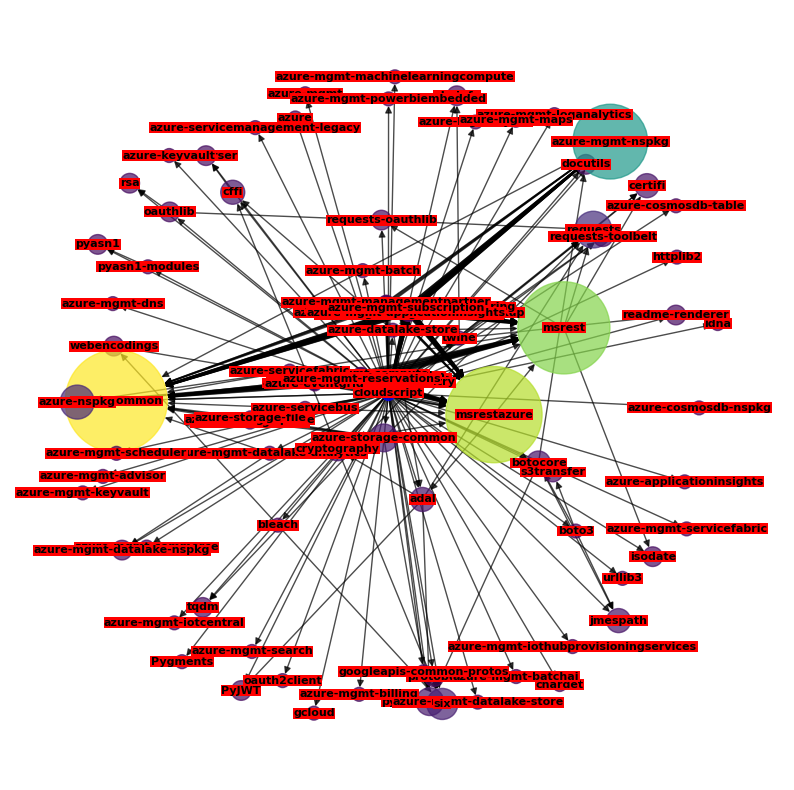

Nodes: 121
Edges: 340
Average degree of cloudscript librariesio graph:  2.809917355371901
Average clustering coefficient of cloudscript librariesio graph:  0.23247551950561895


In [14]:
cludscript_librariesio_G = draw_package_deep_network(librariesio_G, 'cloudscript', 1)
print(f'Nodes: {cludscript_librariesio_G.number_of_nodes()}')
print(f'Edges: {cludscript_librariesio_G.number_of_edges()}')
print("Average degree of cloudscript librariesio graph: ", cludscript_librariesio_G.number_of_edges() / cludscript_librariesio_G.number_of_nodes())
print("Average clustering coefficient of cloudscript librariesio graph: ", nx.average_clustering(cludscript_librariesio_G))

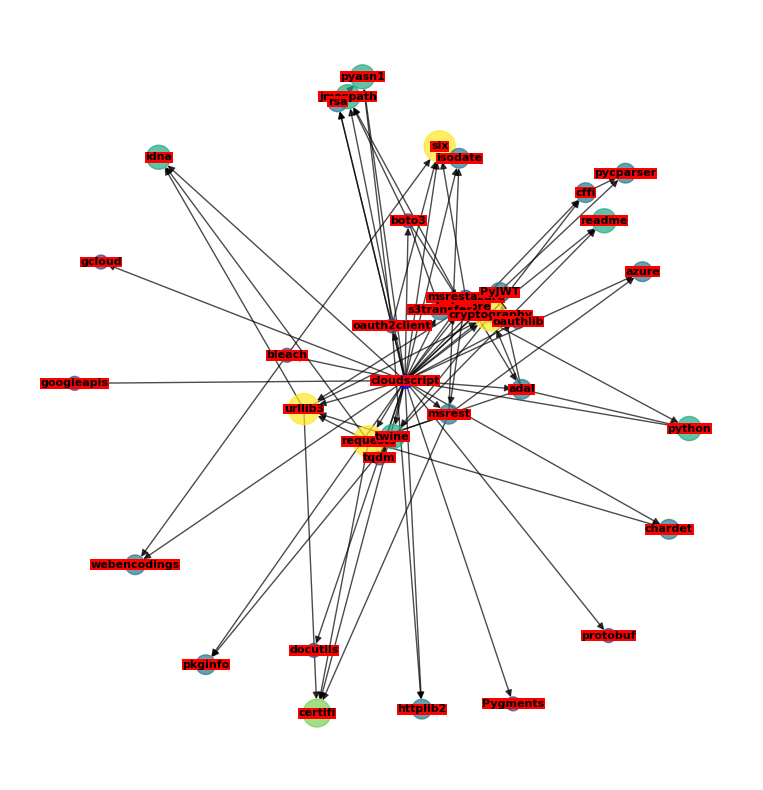

Nodes: 37
Edges: 82
Average degree of cloudscript scraped graph:  2.2162162162162162
Average clustering coefficient of cloudscript scraped graph:  0.3204954954954955


In [15]:
cloudscript_scraped_G = draw_package_deep_network(scraped_G, 'cloudscript', 1)
print(f'Nodes: {cloudscript_scraped_G.number_of_nodes()}')
print(f'Edges: {cloudscript_scraped_G.number_of_edges()}')
print("Average degree of cloudscript scraped graph: ", cloudscript_scraped_G.number_of_edges() / cloudscript_scraped_G.number_of_nodes())
print("Average clustering coefficient of cloudscript scraped graph: ", nx.average_clustering(cloudscript_scraped_G))

###### Top out degree scraped packages evolution

##### Global out degree distribution

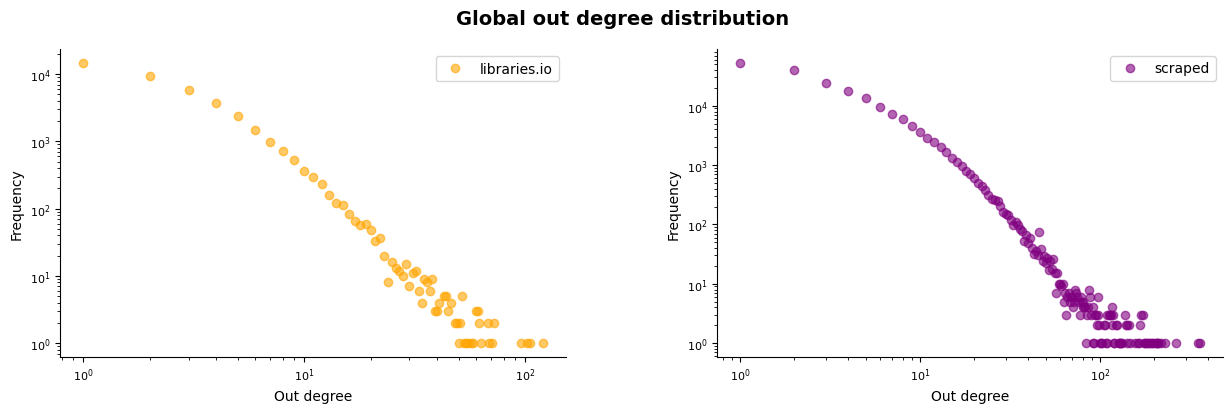

In [98]:
# Global out degree distribution
# ------------------------------

# Libraries.io graph
libio_outd = [x[1] for x in librariesio_G.out_degree()]
libio_outd.sort(reverse=True)
outd_dist_libio = dict(Counter(libio_outd))

# Scraped graph
scraped_outd = [x[1] for x in scraped_G.out_degree()]
scraped_outd.sort(reverse=True)
outd_dist_scraped = dict(Counter(scraped_outd))

plt.figure(figsize=(15, 4))


# title
plt.suptitle('Global out degree distribution', fontsize=14, fontweight='bold')
plt.subplots_adjust(wspace=0.3)

# Plot dot plot
plt.subplot(1, 2, 1)
x, y = zip(*outd_dist_libio.items())
plt.plot(x, y, label='libraries.io', color='orange', marker='o', linestyle='None', alpha=0.6)
# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)

plt.ylabel('Frequency')
plt.xlabel('Out degree')
plt.xscale('log')
plt.yscale('log')
plt.legend()


# Plot dot plot
plt.subplot(1, 2, 2)
x, y = zip(*outd_dist_scraped.items())
plt.plot(x, y, label='scraped', color='purple', marker='o', linestyle='None', alpha=0.6)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)

plt.ylabel('Frequency')
plt.xlabel('Out degree')
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.show()


#### **3 - In degree**

##### Evolution

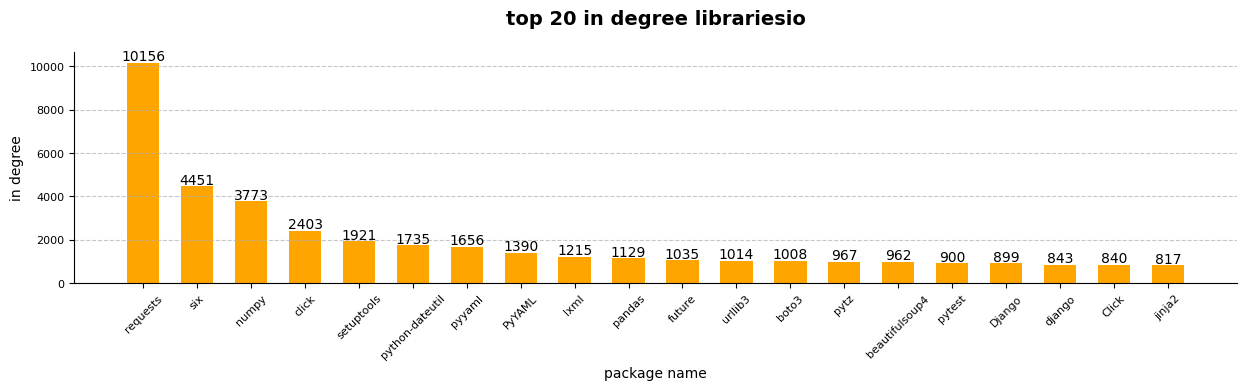

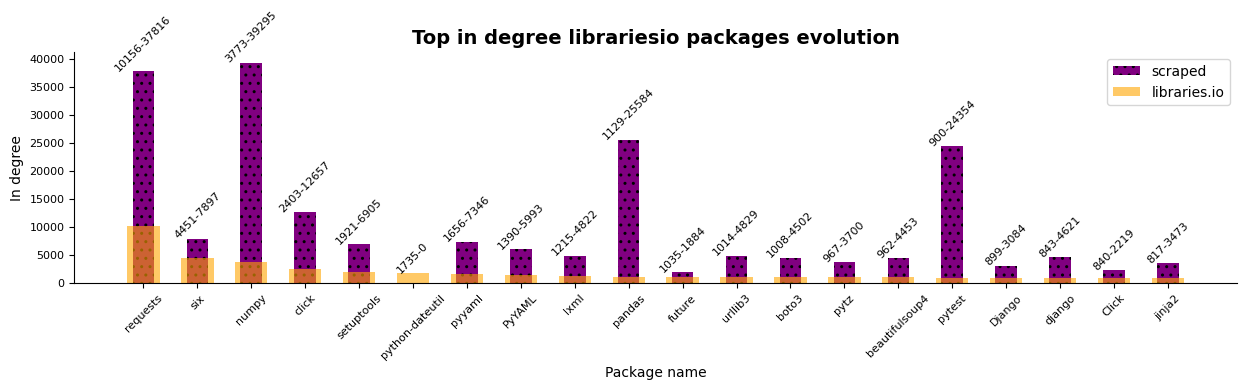

In [17]:
# Top 10 in degree (libraries.io and scraped input metrics)
# --------------------

libio_t20_ind = sorted(librariesio_G.in_degree(), key=lambda x: x[1], reverse=True)[:20]

plot_dict(
    d = dict(libio_t20_ind),
    title = 'top 20 in degree librariesio',
    xlabel = 'package name',
    ylabel = 'in degree',
    rotation = 0,
    size = (15, 3),
    offset = 300,
    label_size = 8,
    font_size = 14,
    label_rotation = 45,
    w=0.6
)


# Top in degree libraries.io packages evolution
# ---------------------------------------------

# Get in degree of each node of top 10 in degree librariesio using the scraped graph
top10_ind_libio_at_scraped = []
for node in libio_t20_ind:
    if node[0] in scraped_G.nodes():
        top10_ind_libio_at_scraped.append((node[0], scraped_G.in_degree(node[0])))
    else:
        top10_ind_libio_at_scraped.append((node[0], 0))
        
# Plot comparison
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in top10_ind_libio_at_scraped],
    [x[1] for x in top10_ind_libio_at_scraped],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..',

)

plt.bar(
    [x[0] for x in libio_t20_ind],
    [x[1] for x in libio_t20_ind],
    label='libraries.io',
    color='orange',
    width=0.6,
    alpha=0.6
)

for i, v, i2, v2 in zip( [x[0] for x in libio_t20_ind], [x[1] for x in libio_t20_ind], [x[0] for x in top10_ind_libio_at_scraped], [x[1] for x in top10_ind_libio_at_scraped]):
    plt.text(i, max(v,v2)+50, f'{v}-{v2}', color='black', ha='center', rotation=45, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)

plt.title('Top in degree librariesio packages evolution', fontsize=14, fontweight='bold')
plt.xlabel('Package name')
plt.ylabel('In degree')
plt.xticks(rotation=45)
plt.legend()

plt.show()
    

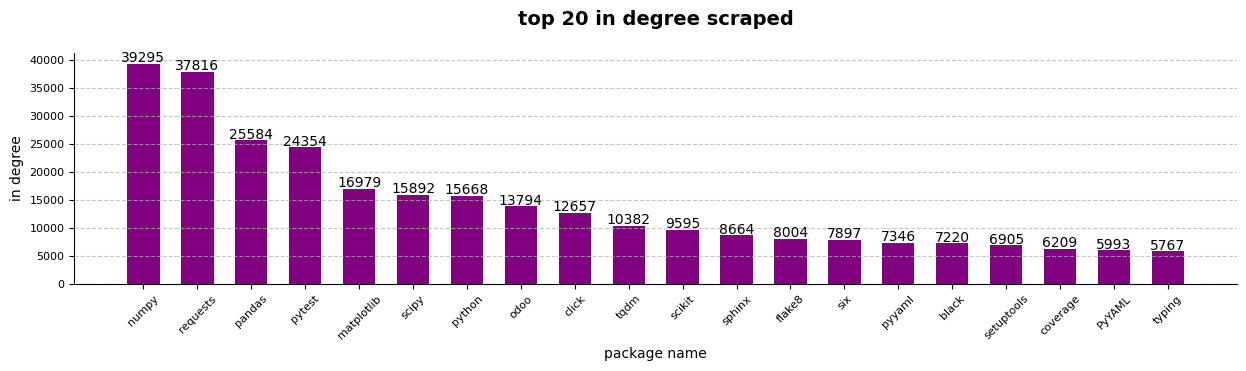

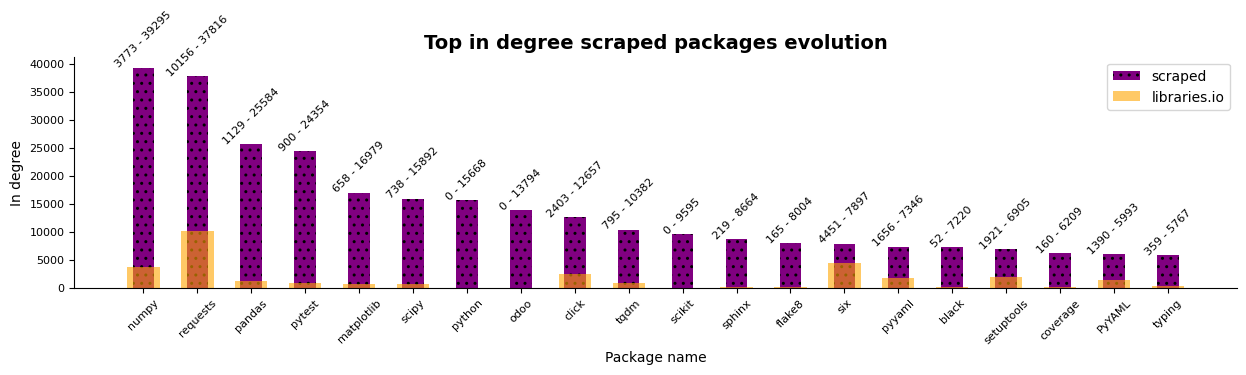

In [18]:
scraped_t20_ind = sorted(scraped_G.in_degree(), key=lambda x: x[1], reverse=True)[:20]

plot_dict(
    d = dict(scraped_t20_ind),
    title = 'top 20 in degree scraped',

    xlabel = 'package name',
    ylabel = 'in degree',
    rotation = 0,
    size = (15, 3),
    offset = 1000,
    label_size = 8,
    font_size = 14,
    label_rotation = 45,
    color = 'purple',

    w=0.6
)

# Top in degree scraped packages evolution
# ----------------------------------------

# Get in degree of each node of top 10 in degree scraped using the libraries.io graph
top10_ind_scraped_at_libio = []
for node in scraped_t20_ind:
    if node[0] in librariesio_G.nodes():
        top10_ind_scraped_at_libio.append((node[0], librariesio_G.in_degree(node[0])))
    else:
        top10_ind_scraped_at_libio.append((node[0], 0))

# Plot comparison
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in scraped_t20_ind],
    [x[1] for x in scraped_t20_ind],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top10_ind_scraped_at_libio],
    [x[1] for x in top10_ind_scraped_at_libio],
    label='libraries.io',
    color='orange',
    width=0.6,
    alpha=0.6,
)

for i, v, i2, v2 in zip( [x[0] for x in scraped_t20_ind], [x[1] for x in scraped_t20_ind], [x[0] for x in top10_ind_scraped_at_libio], [x[1] for x in top10_ind_scraped_at_libio]):
    plt.text(i, max(v,v2)+50, f'{v2} - {v}', color='black', ha='center', rotation=45, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)

plt.title('Top in degree scraped packages evolution', fontsize=14, fontweight='bold')
plt.xlabel('Package name')
plt.ylabel('In degree')
plt.xticks(rotation=45)
plt.legend()

plt.show()



##### Global in degree distribution

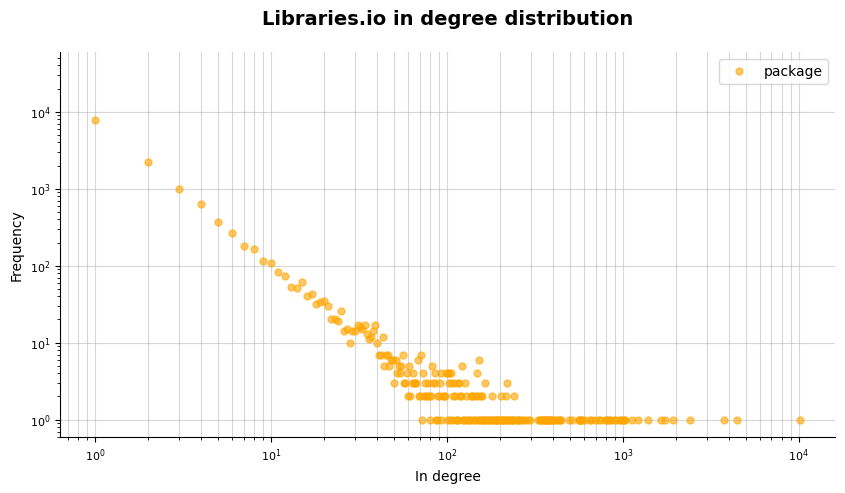

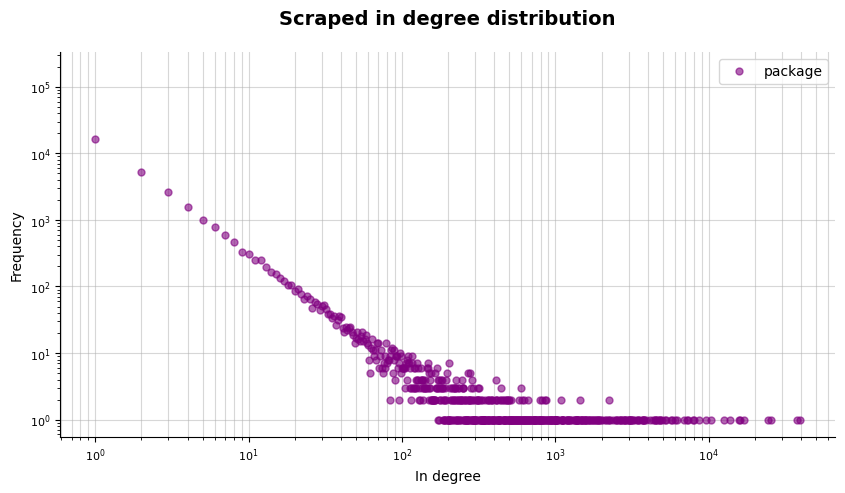

In [143]:
# Global in degree distribution
# -----------------------------

# Libraries.io
libio_in_degree = [x[1] for x in librariesio_G.in_degree()]
libio_in_degree.sort(reverse=True)
plt.figure(figsize=(10, 5))
x, y = zip(*Counter(libio_in_degree).items())
plt.plot(x, y, color='orange', alpha=0.6, marker='.', linestyle='None', markersize=10, label='package')


plt.title('Libraries.io in degree distribution', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('In degree')
plt.ylabel('Frequency')
plt.xscale('log')
plt.yscale('log')
# grid
plt.grid(axis='y', alpha=0.5)
plt.grid(axis='x', alpha=0.5, which='both')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.legend()
plt.show()


# Scraped
scraped_in_degree = [x[1] for x in scraped_G.in_degree()]
scraped_in_degree.sort(reverse=True)
plt.figure(figsize=(10, 5))
x, y = zip(*Counter(scraped_in_degree).items())
plt.plot(x, y, color='purple', alpha=0.6, marker='.', linestyle='None', markersize=10, label='package')
plt.xscale('log')
plt.yscale('log')
plt.title('Scraped in degree distribution', fontsize=14, fontweight='bold',pad=20)
plt.xlabel('In degree')
plt.ylabel('Frequency')
# grid
plt.grid(axis='y', alpha=0.5)
plt.grid(axis='x', alpha=0.5, which='both')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
# set max y axis value
plt.legend()
plt.show()




#### **4 - Pagerrank**

##### Evolution

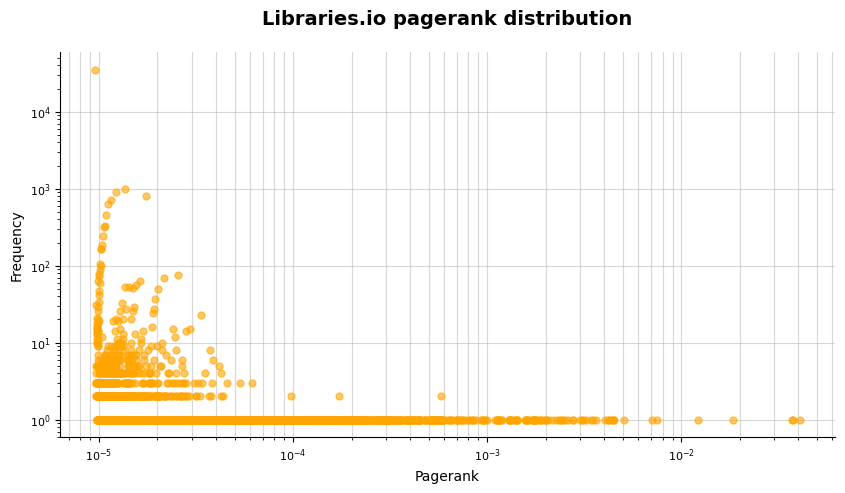

In [107]:
# Pagerank distribution
# ---------------------

# Libraries.io
libio_pagerank = list(dict(nx.pagerank(librariesio_G)).values())
libio_pagerank = sorted(libio_pagerank, reverse=True)

plt.figure(figsize=(10, 5))
x, y = zip(*Counter(libio_pagerank).items())
plt.plot(x, y, color='orange', alpha=0.6, marker='.', linestyle='None', markersize=10, label='package')
plt.title('Libraries.io pagerank distribution', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Pagerank')
plt.ylabel('Frequency')
plt.xscale('log')
plt.yscale('log')
plt.grid(axis='y', alpha=0.5)
plt.grid(axis='x', alpha=0.5, which='both')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.legend()
plt.show()

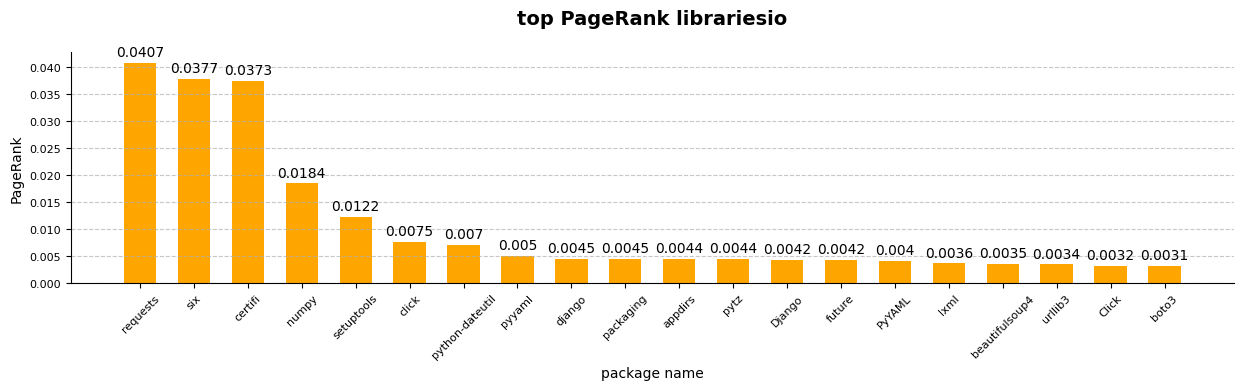

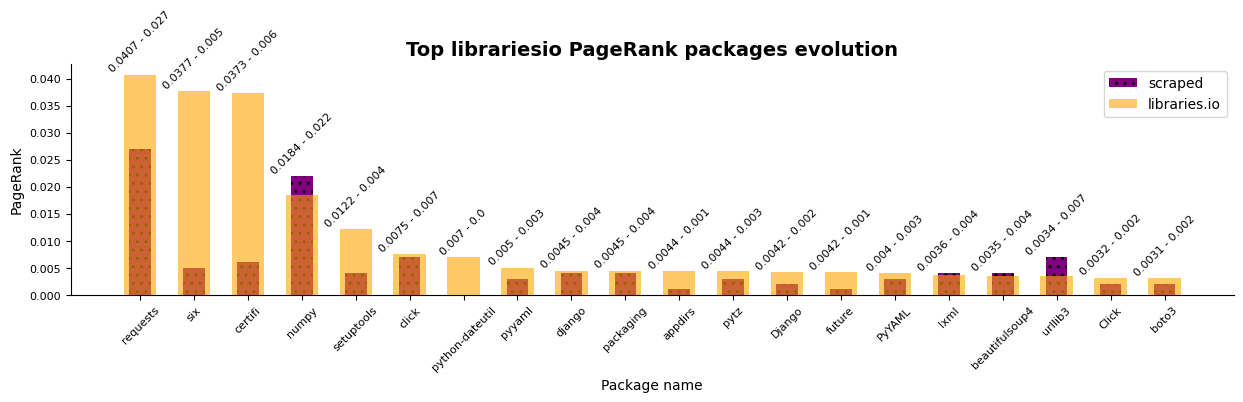

In [21]:
# Top 20 PageRank 
# ---------------

libio_t20_pr = sorted(nx.pagerank(librariesio_G).items(), key=lambda x: x[1], reverse=True)[:20]
libio_t20_pr = [(x[0], round(x[1], 4)) for x in libio_t20_pr]

plot_dict(
    d = dict(libio_t20_pr),
    title = 'top PageRank librariesio',
    xlabel = 'package name',
    ylabel = 'PageRank',
    rotation = 0,
    size = (15, 3),
    offset = 0.002,
    label_size = 8,
    font_size = 14,
    label_rotation = 45,
    w=0.6
)


# Plot evolution of top PageRank librariesio packages
# ---------------------------------------------------

# Get PageRank of each node of top PageRank librariesio using the scraped graph
pr = nx.pagerank(scraped_G)
top10_pr_libio_at_scraped = []
for node in libio_t20_pr:
    if node[0] in scraped_G.nodes():
        top10_pr_libio_at_scraped.append((node[0], round(pr[node[0]], 3)))
    else:
        top10_pr_libio_at_scraped.append((node[0], 0))

# Plot comparison
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in top10_pr_libio_at_scraped],
    [x[1] for x in top10_pr_libio_at_scraped],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in libio_t20_pr],
    [x[1] for x in libio_t20_pr],
    label='libraries.io',
    color='orange',
    width=0.6,
    alpha=0.6
)

for i, v, i2, v2 in zip([x[0] for x in libio_t20_pr], [x[1] for x in libio_t20_pr], [x[0] for x in top10_pr_libio_at_scraped], [x[1] for x in top10_pr_libio_at_scraped]):
    plt.text(i, max(v,v2)+0.0005, f'{v} - {v2}', color='black', ha='center', rotation=45, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size

plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)

plt.title('Top librariesio PageRank packages evolution', fontsize=14, fontweight='bold')
plt.xlabel('Package name')
plt.ylabel('PageRank')
plt.xticks(rotation=45)
plt.legend()
plt.show()

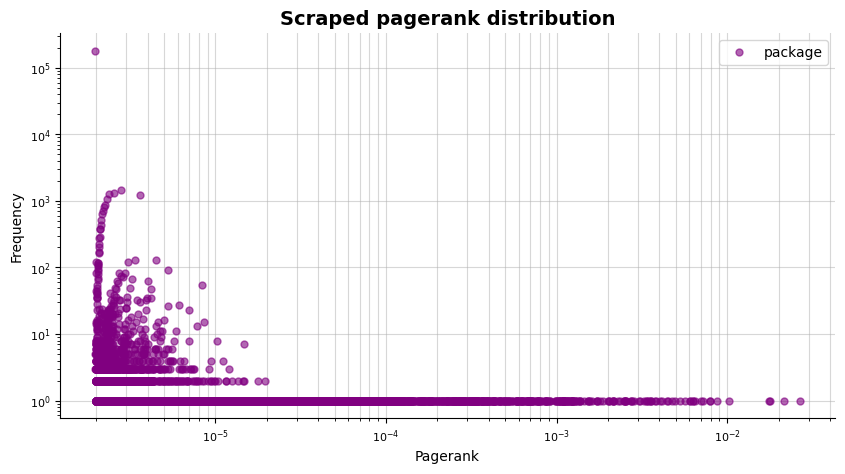

In [141]:
# Pagerank distribution
# ---------------------

# Libraries.io
scraped_pagerank = list(dict(nx.pagerank(scraped_G)).values())
scraped_pagerank = sorted(scraped_pagerank, reverse=True)
plt.figure(figsize=(10, 5))
x, y = zip(*Counter(scraped_pagerank).items())
plt.plot(x, y, color='purple', alpha=0.6, marker='.', linestyle='None', markersize=10, label='package')
plt.title('Scraped pagerank distribution', fontsize=14, fontweight='bold')
plt.xlabel('Pagerank')
plt.ylabel('Frequency')
plt.xscale('log')
plt.yscale('log')
plt.grid(axis='y', alpha=0.5)
plt.grid(axis='x', alpha=0.5, which='both')


# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.legend()

plt.show()

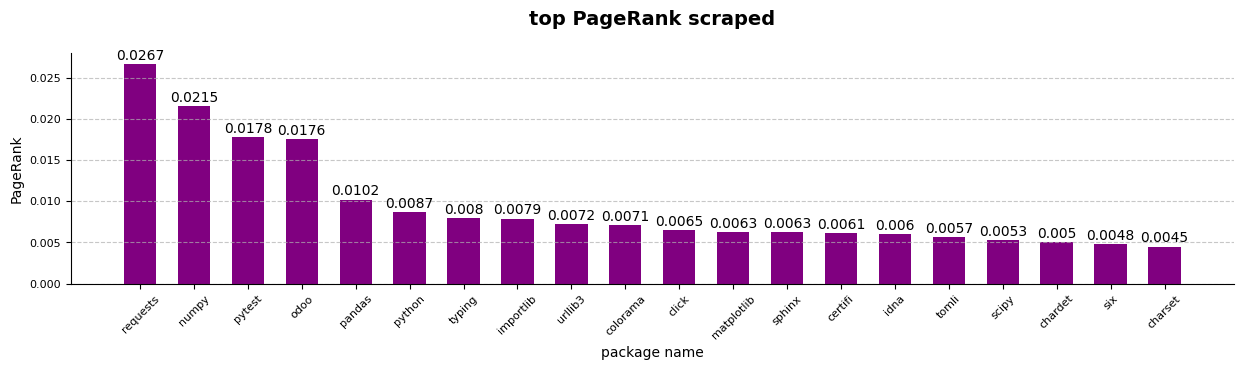

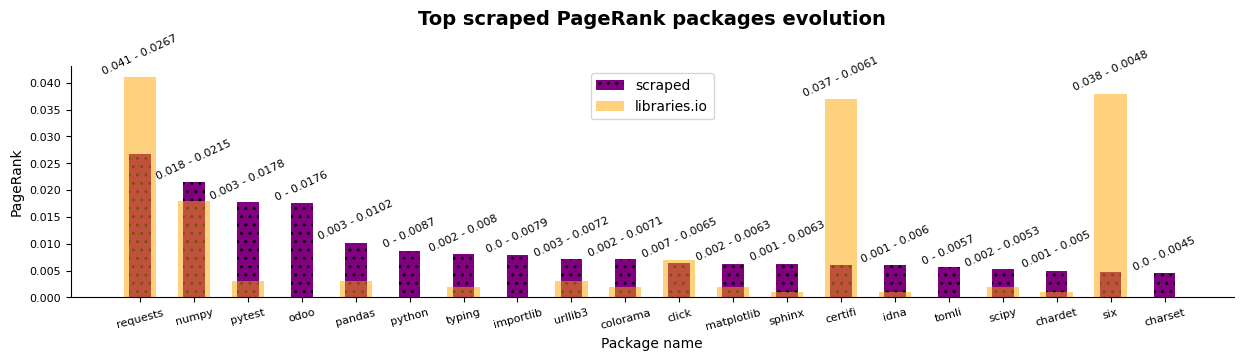

In [23]:
scraped_t20_pr = sorted(nx.pagerank(scraped_G).items(), key=lambda x: x[1], reverse=True)[:20]
scraped_t20_pr = [(x[0], round(x[1], 4)) for x in scraped_t20_pr]

plot_dict(
    d = dict(scraped_t20_pr),
    title = 'top PageRank scraped',
    xlabel = 'package name',
    ylabel = 'PageRank',
    rotation = 0,
    size = (15, 3),
    offset = 0.001,
    label_size = 8,
    font_size = 14,
    label_rotation = 45,
    color = 'purple',
    w=0.6
)

# Plot evolution of top PageRank scraped packages
# ---------------------------------------------------

# Get PageRank of each node of top PageRank scraped using the libraries.io graph
pr = nx.pagerank(librariesio_G)
top10_pr_scraped_at_libio = []
for node in scraped_t20_pr:
    if node[0] in librariesio_G.nodes():
        top10_pr_scraped_at_libio.append((node[0], round(pr[node[0]], 3)))
    else:
        top10_pr_scraped_at_libio.append((node[0], 0))

# Plot comparison
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in scraped_t20_pr],
    [x[1] for x in scraped_t20_pr],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top10_pr_scraped_at_libio],
    [x[1] for x in top10_pr_scraped_at_libio],
    label='libraries.io',
    color='orange',
    width=0.6,
    alpha=0.5
)

for i, v, i2, v2 in zip([x[0] for x in scraped_t20_pr], [x[1] for x in scraped_t20_pr], [x[0] for x in top10_pr_scraped_at_libio], [x[1] for x in top10_pr_scraped_at_libio]):
    plt.text(i, max(v,v2)+0.0005, f'{v2} - {v}', color='black', ha='center', rotation=25, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.title('Top scraped PageRank packages evolution', fontsize=14, fontweight='bold', pad=30)
plt.xlabel('Package name')
plt.ylabel('PageRank')
plt.xticks(rotation=15)
plt.legend()
plt.show()


We can compare other interesting metrics as well.

### **Olivia metrics**

In [56]:
# Append the path to the olivia_finder package
import sys
sys.path.append('../../olivia/')

from olivia.model import OliviaNetwork

In [57]:
# Libraries.io model
librariesio_model = OliviaNetwork()
librariesio_model.build_model('../resources/pypi_adjlist_librariesio_filtered.bz2')

# Scraped based model
scraped_model = OliviaNetwork()
scraped_model.build_model('../resources/pypi_adjlist_scraping.bz2')


Reading dependencies file...
Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done
Reading dependencies file...
Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done


#### **1 - Atack vulnerability**

In [26]:
from olivia.networkmetrics import attack_vulnerability

librariesio_model_attack_vulnerability = attack_vulnerability(librariesio_model, normalize=True)
scraped_model_attack_vulnerability = attack_vulnerability(scraped_model, normalize=True)

print('Attack vulnerability librariesio: {}'.format(librariesio_model_attack_vulnerability))
print('Attack vulnerability scraped: {}'.format(scraped_model_attack_vulnerability))
print('Increase in attack vulnerability: {}'.format(scraped_model_attack_vulnerability - librariesio_model_attack_vulnerability))

Computing Reach
     Processing node: 49K      
Computing Reach
     Processing node: 213K      
Attack vulnerability librariesio: 0.38964831866304306
Attack vulnerability scraped: 0.6760852333659719
Increase in attack vulnerability: 0.28643691470292887


#### **2 - Failure vulnerability**

In [27]:
from olivia.networkmetrics import failure_vulnerability

librariesio_model_failure_vulnerability = failure_vulnerability(librariesio_model, normalize=True)
scraped_model_failure_vulnerability = failure_vulnerability(scraped_model, normalize=True)

print('Failure vulnerability librariesio: {}'.format(librariesio_model_failure_vulnerability))
print('Failure vulnerability scraped: {}'.format(scraped_model_failure_vulnerability))
print('Increase in failure vulnerability: {}'.format(scraped_model_failure_vulnerability - librariesio_model_failure_vulnerability))



Reach retrieved from metrics cache
Reach retrieved from metrics cache
Failure vulnerability librariesio: 0.0001738793933286081
Failure vulnerability scraped: 0.0022826054428677265
Increase in failure vulnerability: 0.0021087260495391185


#### **3 - Reach**

In [58]:
from olivia.packagemetrics import Reach

librariesio_reach = librariesio_model.get_metric(Reach)
scraped_reach = scraped_model.get_metric(Reach)

Computing Reach


     Processing node: 49K      
Computing Reach
     Processing node: 213K      


**Top reach**

######

In [59]:
# Top 10 Reach
# ------------

top10_reach_librariesio = librariesio_reach.top(10)
top10_reach_scraped = scraped_reach.top(10)

# Top 10 Reach comparison
top10_reach_comparison = pd.DataFrame(
    {
        'librariesio': top10_reach_librariesio,
        'scraped': top10_reach_scraped
    }
)

top10_reach_comparison

librariesio              scraped
0             (six, 19212)      (numpy, 145000)
1         (certifi, 14155)  (importlib, 142309)
2        (requests, 13655)        (six, 142282)
3        (pyparsing, 8681)   (colorama, 142116)
4        (packaging, 8308)     (typing, 142045)
5          (appdirs, 7874)     (python, 142018)
6       (setuptools, 7340)      (click, 141302)
7  (python-dateutil, 6592)    (chardet, 140543)
8            (numpy, 4937)     (django, 140508)
9            (attrs, 4311)     (Cython, 140502)

**Bottomb reach**

######

In [60]:
# Top 10 least Reach
# ------------------

top10_least_reach_librariesio = librariesio_reach.bottom(10)
top10_least_reach_scraped = scraped_reach.bottom(10)

# Top 10 least Reach comparison
top10_least_reach_comparison = pd.DataFrame(
    {
        'librariesio': top10_least_reach_librariesio,
        'scraped': top10_least_reach_scraped
    }
)

top10_least_reach_comparison

librariesio                 scraped
0           (pytest-testdox, 1)       (lol-id-tools, 1)
1       (pytest-json-report, 1)           (logipass, 1)
2      (pytest-random-order, 1)             (loghub, 1)
3           (pytest-twisted, 1)      (lodek-bookman, 1)
4  (pytest-markers-presence, 1)           (lockdoor, 1)
5              (pytest-only, 1)  (llamazure.azgraph, 1)
6                 (nutsflow, 1)         (livyclient, 1)
7                   (mydict, 1)       (livingmodels, 1)
8           (optimuspyspark, 1)      (littlefieldpy, 1)
9                    (1pass, 1)      (0x-sra-client, 1)

**Top reach increase, decrease and variation**

######

In [61]:
# Dataframe with the differences between the two models
librariesio_reach_df = pd.DataFrame(librariesio_reach.results_dict, index=['librariesio']).T
scraped_reach_df = pd.DataFrame(scraped_reach.results_dict, index=['scraped']).T

reach_df = pd.concat([librariesio_reach_df, scraped_reach_df], axis=1)
reach_df['increment'] = reach_df['scraped'] - reach_df['librariesio']
reach_df.sort_values(by='increment', ascending=False, inplace=True)
reach_df.head(10)

librariesio   scraped  increment
importlib              24.0  142309.0   142285.0
typing               1414.0  142045.0   140631.0
colorama             1531.0  142116.0   140585.0
Cython                 74.0  140502.0   140428.0
genshi                  5.0  140394.0   140389.0
BeautifulSoup4         70.0  140393.0   140323.0
cssselect             239.0  140393.0   140154.0
html5lib              254.0  140386.0   140132.0
numpy                4937.0  145000.0   140063.0
webencodings          733.0  140387.0   139654.0

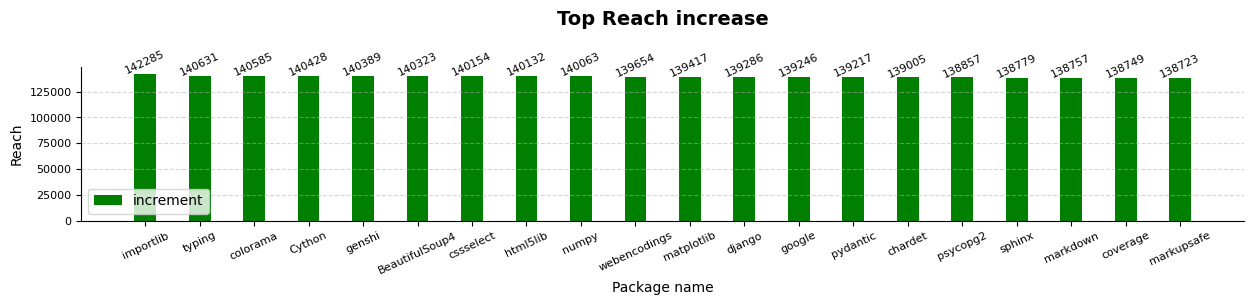

In [62]:
# Top reach increase
# ------------------

increment = reach_df.head(20)

# Plot top reach increase
plt.figure(figsize=(15, 2))

plt.bar(
    increment.index,
    increment['increment'],
    label='increment',
    color='green',
    width=0.4,
)

for i, v in zip(increment.index, increment['increment']):
    plt.text(i, v, f'{int(v)}', color='black', ha='center', rotation=25, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8, rotation=25)
plt.gca().tick_params(axis='y', labelsize=8)

plt.title('Top Reach increase', fontsize=14, fontweight='bold', pad=30)
plt.xlabel('Package name')
plt.ylabel('Reach')
plt.legend(loc='lower left')
# grid
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


/tmp/ipykernel_18767/438345627.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decrement.sort_values(by='increment', ascending=True, inplace=True)


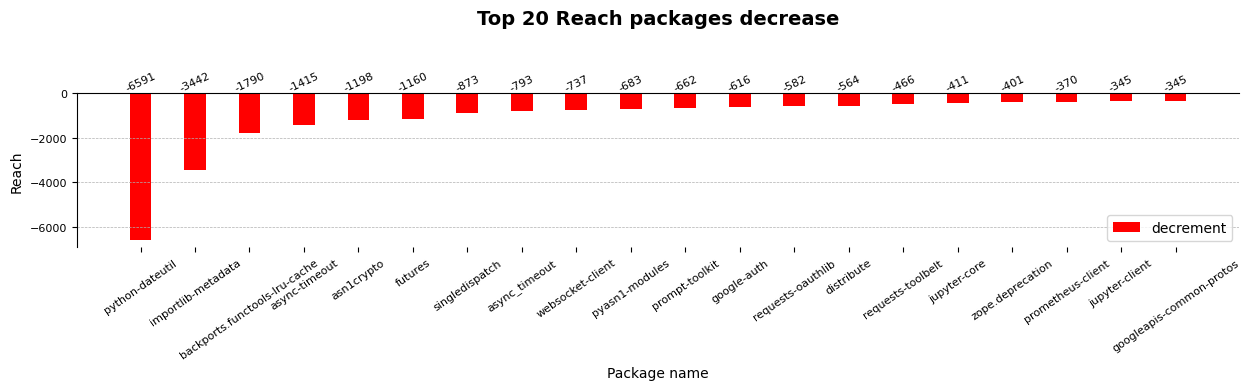

In [110]:
# Decrease in Reach
reach_df = reach_df.dropna()
decrement = reach_df.tail(20)

# sort by increment
decrement.sort_values(by='increment', ascending=True, inplace=True)

# Plot
plt.figure(figsize=(15, 2))

plt.bar(
    decrement.index,
    decrement['increment'],
    label='decrement',
    color='red',
    width=0.4,
)

for i, v in zip(decrement.index, decrement['increment']):
    plt.text(i, 100, f'{int(v)}', color='black', ha='center', rotation=25, fontsize=8)

# Adjusting plot borders
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.title('Top 20 Reach packages decrease', fontsize=14, fontweight='bold', pad=50)
plt.xlabel('Package name')
plt.ylabel('Reach')
plt.xticks(rotation=35)
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()


No handles with labels found to put in legend.


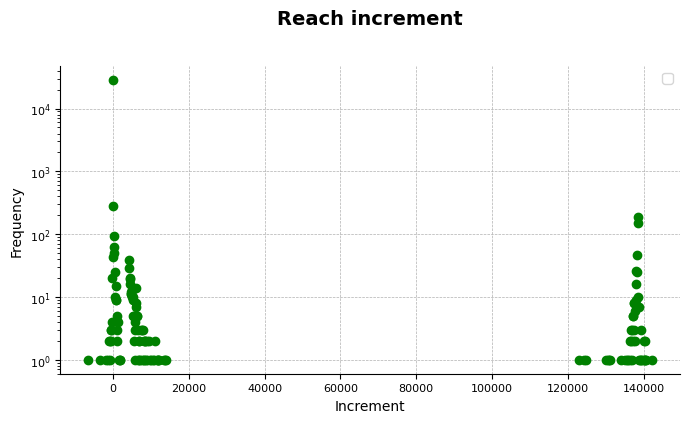

In [129]:
# Reach variation
# ---------------

reach_increment = list(reach_df['increment'].dropna())

# Plot list of reach increase
plt.figure(figsize=(8, 4))

# agrupar em intervalos de 100
reach_increment = [int(x / 100) * 100 for x in reach_increment]
x, y = zip(*Counter(reach_increment).items())

plt.plot(x, y, color='green', marker='o', linestyle='None', label="package")

plt.title('Reach increment', fontsize=14, fontweight='bold', pad=30)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.xlabel('Increment')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('linear')
plt.yscale('log')
plt.show()

**Reach evolution**

######

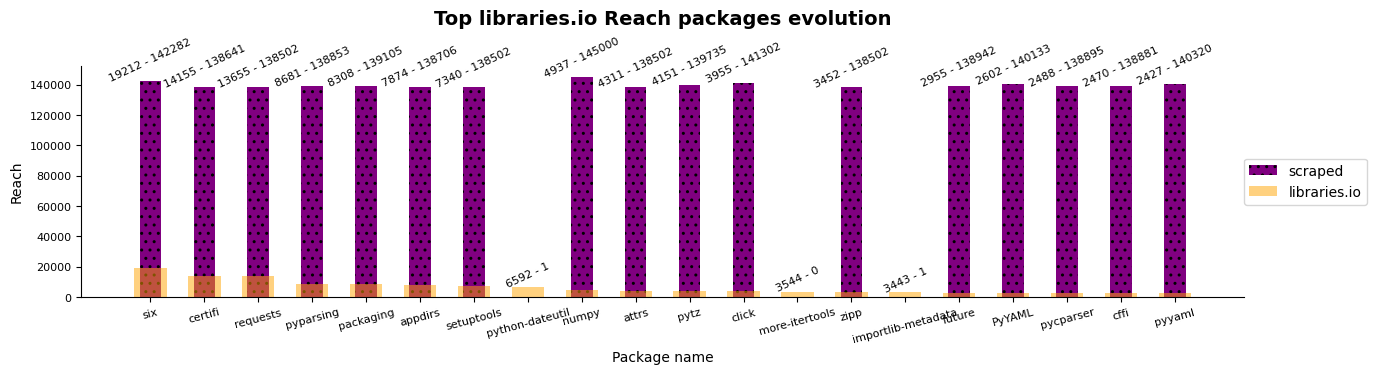

In [56]:

# Top librariesio reach evolution 
# --------------------------------

# Get the top 10 packages with the highest Reach in the libraries.io model
top_reach_librariesio = dict(librariesio_reach.top(20))

# Get the Reach of the packages in the scraped model
top_reach_scraped = {}
reach_scraped = scraped_reach.results_dict
for package in top_reach_librariesio.keys():
    if package in reach_scraped.keys():
        top_reach_scraped[package] = reach_scraped[package]
    else:
        top_reach_scraped[package] = 0


# Plot comparison
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in top_reach_scraped.items()],
    [x[1] for x in top_reach_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_reach_librariesio.items()],
    [x[1] for x in top_reach_librariesio.items()],
    label='libraries.io',
    color='orange',
    width=0.6,
    alpha=0.5,
)

for i, v, i2, v2 in zip([x[0] for x in top_reach_librariesio.items()], [x[1] for x in top_reach_librariesio.items()], [x[0] for x in top_reach_scraped.items()], [x[1] for x in top_reach_scraped.items()]):
    plt.text(i, max(v,v2)+0.0005, f'{v} - {v2}', color='black', ha='center', rotation=25, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.title('Top libraries.io Reach packages evolution', fontsize=14, fontweight='bold', pad=30)
plt.xlabel('Package name')
plt.ylabel('Reach')
plt.xticks(rotation=15)
plt.legend(loc=(1, 0.4))
plt.show()

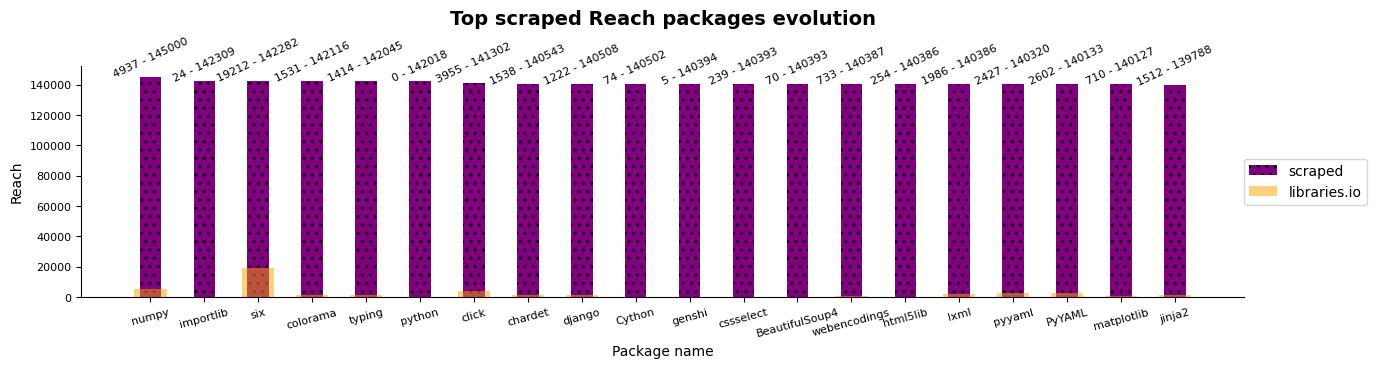

In [63]:
# Top scraped reach evolution
# ----------------------------

# Get the top 10 packages with the highest Reach in the scraped model
top_reach_scraped = dict(scraped_reach.top(20))

# Get the Reach of the packages in the libraries.io model
top_reach_librariesio = {}
reach_librariesio = librariesio_reach.results_dict
for package in top_reach_scraped.keys():
    if package in reach_librariesio.keys():
        top_reach_librariesio[package] = reach_librariesio[package]
    else:
        top_reach_librariesio[package] = 0


# Plot comparison
plt.figure(figsize=(15, 3))
plt.bar(
    [x[0] for x in top_reach_scraped.items()],
    [x[1] for x in top_reach_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)
plt.bar(
    [x[0] for x in top_reach_librariesio.items()],
    [x[1] for x in top_reach_librariesio.items()],
    label='libraries.io',
    color='orange',
    width=0.6,
    alpha=0.5,
)

for i, v, i2, v2 in zip([x[0] for x in top_reach_librariesio.items()], [x[1] for x in top_reach_librariesio.items()], [x[0] for x in top_reach_scraped.items()], [x[1] for x in top_reach_scraped.items()]):
    plt.text(i, max(v,v2)+0.0005, f'{v} - {v2}', color='black', ha='center', rotation=25, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.title('Top scraped Reach packages evolution', fontsize=14, fontweight='bold', pad=30)
plt.xlabel('Package name')
plt.ylabel('Reach')
plt.xticks(rotation=15)
plt.legend(loc=(1, 0.4))
plt.show()


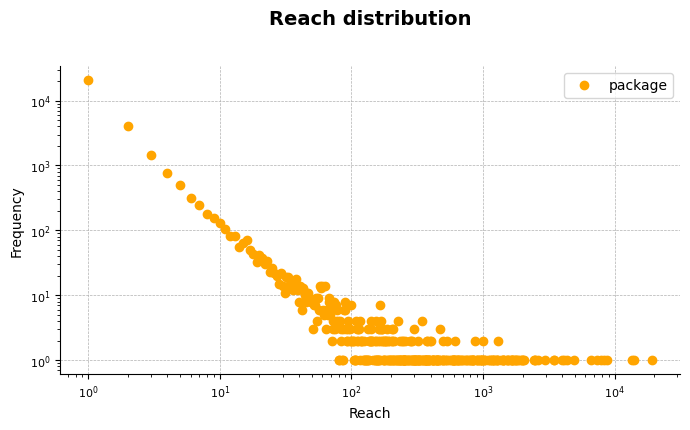

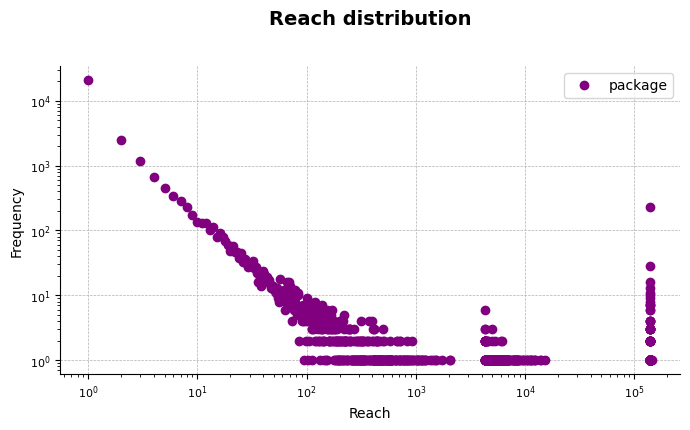

In [208]:
# Reach distribution for libraries.io
# -----------------------------------

# Plot distribution
plt.figure(figsize=(8, 4))
reach = list(reach_df['librariesio'].dropna())
x, y = zip(*Counter(reach).items())

plt.plot(x, y, color='orange', marker='o', linestyle='None', label="package")

plt.title('Reach distribution', fontsize=14, fontweight='bold', pad=30)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.xlabel('Reach')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()


# Reach distribution for scraped
# -----------------------------

# Plot distribution
plt.figure(figsize=(8, 4))
reach = list(reach_df['scraped'].dropna())
x, y = zip(*Counter(reach).items())

plt.plot(x, y, color='purple', marker='o', linestyle='None', label="package")

plt.title('Reach distribution', fontsize=14, fontweight='bold', pad=30)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.xlabel('Reach')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()



#### **4 - Impact**

In [121]:
from olivia.packagemetrics import Impact

librariesio_impact = librariesio_model.get_metric(Impact)
scraped_impact = scraped_model.get_metric(Impact)

Computing Impact


     Processing node: 49K      
Computing Impact
     Processing node: 213K      


**Top impact**

######

In [130]:
# Top 10 impact
# -------------

top10_impact_librariesio = librariesio_impact.top(10)
top10_impact_scraped = scraped_impact.top(10)

# Top 10 impact comparison
top10_impact_comparison = pd.DataFrame(
    {
        'librariesio': top10_impact_librariesio,
        'scraped': top10_impact_scraped
    }
)

top10_impact_comparison

librariesio               scraped
0             (six, 36757)       (numpy, 448177)
1         (certifi, 18739)         (six, 424014)
2        (requests, 17740)      (python, 422180)
3       (pyparsing, 14111)   (importlib, 420861)
4       (packaging, 13433)      (typing, 417287)
5         (appdirs, 12619)    (colorama, 416663)
6      (setuptools, 11803)  (matplotlib, 414520)
7  (python-dateutil, 9825)     (chardet, 413067)
8            (numpy, 7396)      (Cython, 412181)
9             (pytz, 6878)       (click, 411954)

**Bottom impact**

######

In [131]:
# Top 10 less impact
# ------------------

top10_less_impact_librariesio = librariesio_impact.bottom(10)
top10_less_impact_scraped = scraped_impact.bottom(10)

# Top 10 less impact comparison
top10_less_impact_comparison = pd.DataFrame(
    {
        'librariesio': top10_less_impact_librariesio,
        'scraped': top10_less_impact_scraped
    }
)

top10_less_impact_comparison

librariesio                         scraped
0           (pytest-testdox, 0)                (LogReporter, 0)
1       (pytest-json-report, 0)             (LogoRestClient, 0)
2      (pytest-random-order, 0)                 (logger-hub, 0)
3           (pytest-twisted, 0)         (lockdoor-framework, 0)
4  (pytest-markers-presence, 0)  (location-ipfire-db-reader, 0)
5              (pytest-only, 0)                  (load-m3u8, 0)
6                 (nutsflow, 0)                 (llmapi-cli, 0)
7                   (mydict, 0)                   (lixinAPI, 0)
8           (optimuspyspark, 0)                  (liveatlas, 0)
9                    (1pass, 0)              (0x-sra-client, 0)

**Top impact increase, decrease y variation**

######

In [133]:
# Dataframe with the increments between the two models
librariesio_impact_df = pd.DataFrame(librariesio_impact.results_dict, index=['librariesio']).T
scraped_impact_df = pd.DataFrame(scraped_impact.results_dict, index=['scraped']).T

impact_df = pd.concat([librariesio_impact_df, scraped_impact_df], axis=1)
impact_df['increment'] = impact_df['scraped'] - impact_df['librariesio']
impact_df.sort_values(by='increment', ascending=False, inplace=True)
impact_df.head(10)

librariesio   scraped  increment
numpy                7396.0  448177.0   440781.0
importlib              24.0  420861.0   420837.0
colorama             1795.0  416663.0   414868.0
typing               2434.0  417287.0   414853.0
matplotlib            748.0  414520.0   413772.0
Cython                 75.0  412181.0   412106.0
chardet              1707.0  413067.0   411360.0
BeautifulSoup4         75.0  411391.0   411316.0
genshi                  5.0  411290.0   411285.0
cssselect             260.0  411490.0   411230.0

<Figure size 1500x300 with 0 Axes>

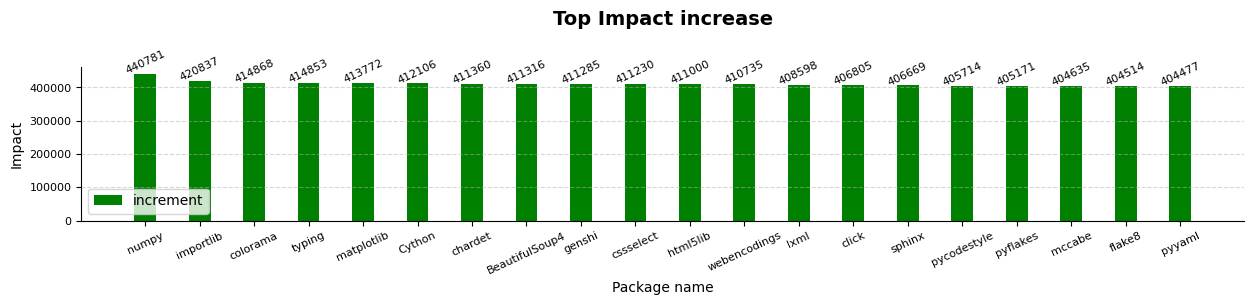

In [134]:
# Plot increment
plt.figure(figsize=(15, 3))
increment = impact_df.head(20)

# Plot top reach increase
plt.figure(figsize=(15, 2))

plt.bar(
    increment.index,
    increment['increment'],
    label='increment',
    color='green',
    width=0.4,
)

for i, v in zip(increment.index, increment['increment']):
    plt.text(i, v, f'{int(v)}', color='black', ha='center', rotation=25, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8, rotation=25)
plt.gca().tick_params(axis='y', labelsize=8)

plt.title('Top Impact increase', fontsize=14, fontweight='bold', pad=30)
plt.xlabel('Package name')
plt.ylabel('Impact')
plt.legend(loc='lower left')
# grid
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


**Top impact decrease**

######

In [135]:
# Decrease in impact
impact_df = impact_df.dropna()
impact_df.tail(10)

librariesio  scraped  increment
pyasn1-modules                      1101.0      0.0    -1101.0
singledispatch                      1213.0     87.0    -1126.0
oslo.utils                          1242.0      0.0    -1242.0
futures                             2277.0    816.0    -1461.0
oslo.i18n                           1503.0      0.0    -1503.0
asn1crypto                          2503.0    817.0    -1686.0
async-timeout                       1828.0      0.0    -1828.0
backports.functools-lru-cache       1944.0      0.0    -1944.0
importlib-metadata                  4677.0      0.0    -4677.0
python-dateutil                     9825.0      0.0    -9825.0

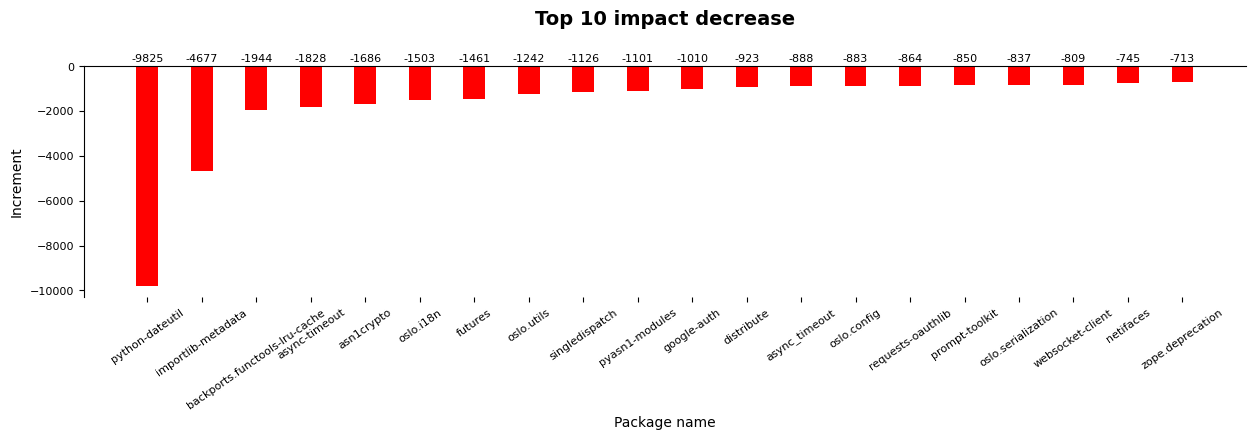

In [ ]:
# Plot decrease
plt.figure(figsize=(15, 3))
decrease = impact_df.tail(20).astype(int)

# sort by increment
decrease.sort_values(by='increment', ascending=True, inplace=True)

plt.bar(
    decrease.index,
    decrease['increment'],
    color='red',
    width=0.4,
)

for i, v in zip(decrease.index, decrease['increment']):
    plt.text(i, 200, f'{v}', color='black', ha='center', rotation=0, fontsize=8)

# Adjusting plot borders
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)

plt.title('Top 10 impact decrease', fontsize=14, fontweight='bold', pad=30)
plt.xlabel('Package name')
plt.ylabel('Increment')
plt.xticks(rotation=35)
plt.show()


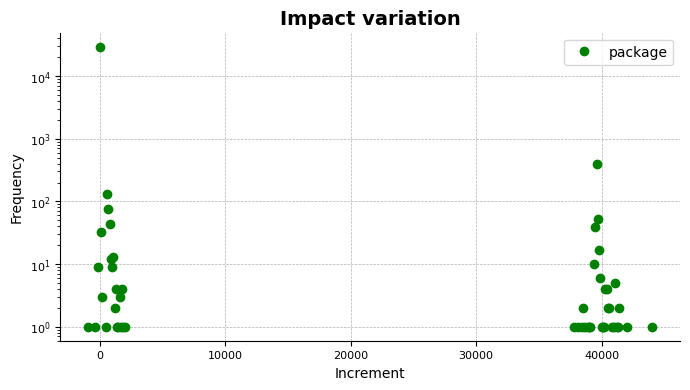

In [198]:
# Reach variation
# ---------------

impact_increase = list(impact_df['increment'].dropna())
impact_increase.sort(reverse=True)

# Plot impact increase
plt.figure(figsize=(8, 4))

# agrupar em intervalos de 100
impact_increase = [int(x / 1000) * 100 for x in impact_increase]
x, y = zip(*Counter(impact_increase).items())

plt.plot(x, y, color='green', marker='o', linestyle='None', label='package')



plt.title('Impact variation', fontsize=14, fontweight='bold')

# Adjusting plot borders

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.ylabel('Frequency')
plt.xlabel('Increment')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('linear')
plt.yscale('log')
plt.show()

**Evolution**

######

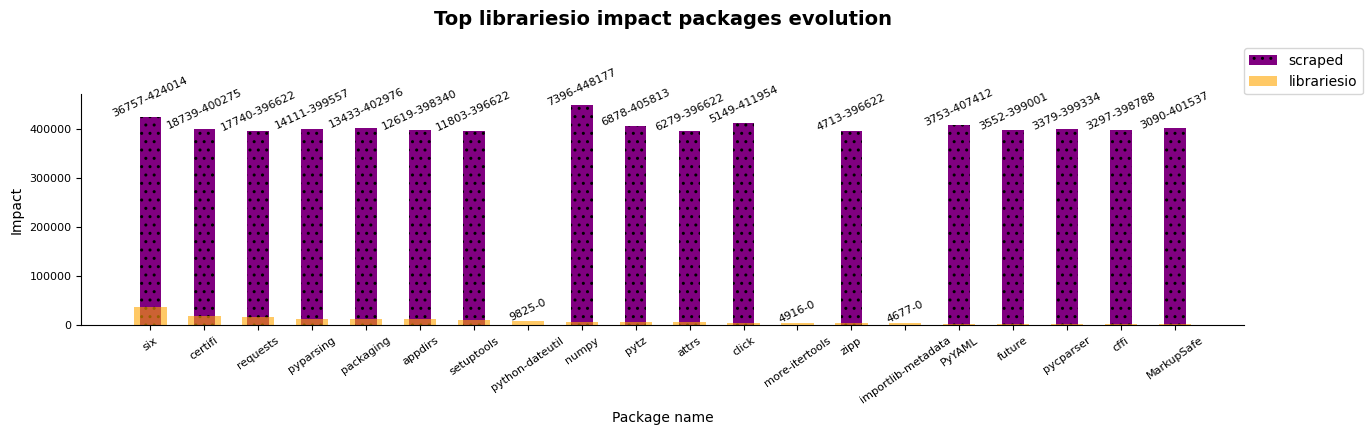

In [72]:
# Top librariesio impact packages evolution
# -----------------------------------------

top_impact_librariesio = dict(librariesio_impact.top(20))

# Get the impact of the top librariesio packages in the scraped model
top_impact_scraped = {}
for package in top_impact_librariesio.keys():
    try:
        top_impact_scraped[package] = scraped_impact.results_dict[package]
    except KeyError:
        top_impact_scraped[package] = 0

# Plot top impact packages evolution
plt.figure(figsize=(15, 3))



plt.bar(
    [x[0] for x in top_impact_scraped.items()],
    [x[1] for x in top_impact_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_impact_librariesio.items()],
    [x[1] for x in top_impact_librariesio.items()],
    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.6,
)

for i, v, v2 in zip([x[0] for x in top_impact_librariesio.items()], [x[1] for x in top_impact_librariesio.items()], [x[1] for x in top_impact_scraped.items()]):
    plt.text(i, max(v,v2), f'{int(v)}-{int(v2)}', color='black', ha='center', rotation=25, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)

plt.title('Top librariesio impact packages evolution', fontsize=14, fontweight='bold', pad=50)

plt.xlabel('Package name')
plt.ylabel('Impact')
plt.xticks(rotation=35)
plt.legend(loc=(1,1))
plt.show()

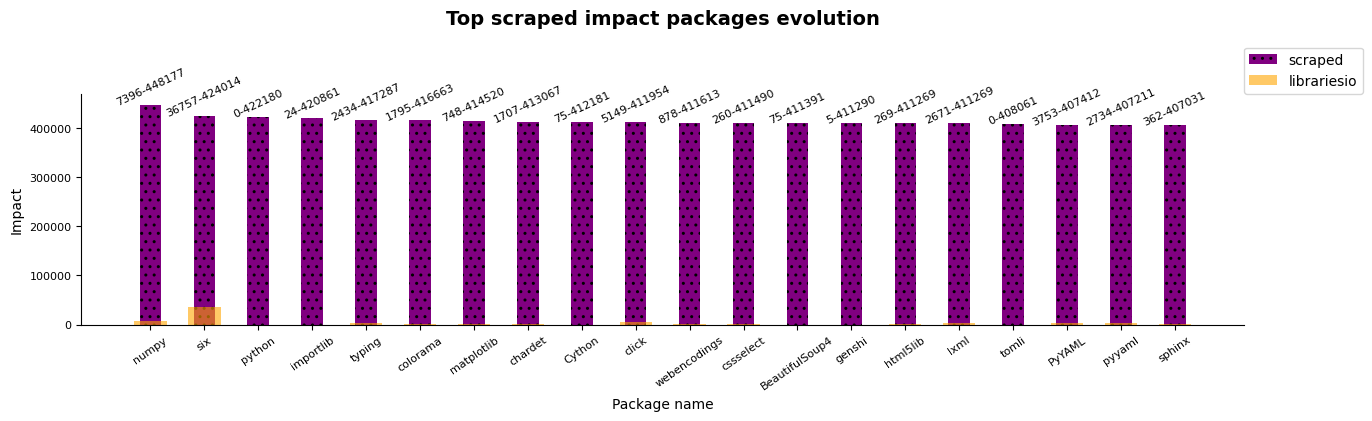

In [73]:
# Top scraped impact packages evolution
# -------------------------------------

# order impact by librariesio value
impact_df.sort_values(by='scraped', ascending=False, inplace=True)
top_impact_scraped = dict(impact_df.head(20)['scraped'])

# Get the impact of the top scraped packages in the librariesio model
top_impact_librariesio = {}
for package in top_impact_scraped.keys():
    try:
        top_impact_librariesio[package] = librariesio_impact.results_dict[package]
    except KeyError:
        top_impact_librariesio[package] = 0

# Plot top impact packages evolution
plt.figure(figsize=(15, 3))
plt.bar(
    [x[0] for x in top_impact_scraped.items()],
    [x[1] for x in top_impact_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_impact_librariesio.items()],
    [x[1] for x in top_impact_librariesio.items()],
    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.6,
)

for i, v, v2 in zip([x[0] for x in top_impact_librariesio.items()], [x[1] for x in top_impact_librariesio.items()], [x[1] for x in top_impact_scraped.items()]):
    plt.text(i, max(v,v2), f'{int(v)}-{int(v2)}', color='black', ha='center', rotation=25, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)

plt.title('Top scraped impact packages evolution', fontsize=14, fontweight='bold', pad=50)

plt.xlabel('Package name')
plt.ylabel('Impact')
plt.xticks(rotation=35)
plt.legend(loc=(1,1))
plt.show()

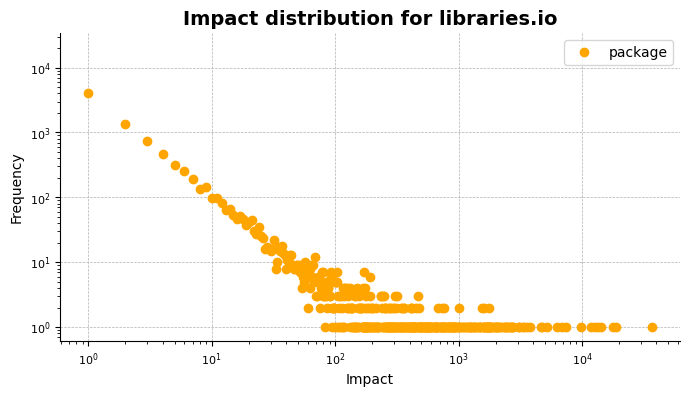

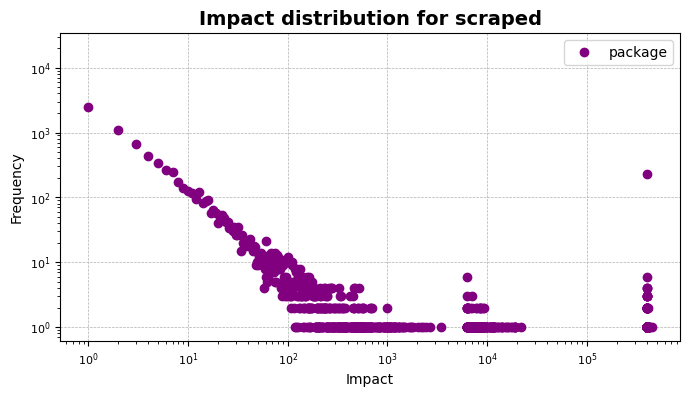

In [210]:
# Impact distribution for libraries.io
# ------------------------------------

# Plot impact distribution
plt.figure(figsize=(8, 4))

impact = list(impact_df['librariesio'].dropna())
x, y = zip(*Counter(impact).items())

plt.plot(x, y, color='orange', marker='o', linestyle='None', label='package')

plt.title('Impact distribution for libraries.io', fontsize=14, fontweight='bold')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.xlabel('Impact')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()

# Impact distribution for scraped
# -------------------------------

# Plot impact distribution
plt.figure(figsize=(8, 4))

impact = list(impact_df['scraped'].dropna())
x, y = zip(*Counter(impact).items())

plt.plot(x, y, color='purple', marker='o', linestyle='None', label='package')
plt.title('Impact distribution for scraped', fontsize=14, fontweight='bold')

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.xlabel('Impact')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()






#### **5 - Surface**

In [144]:
from olivia.packagemetrics import Surface

librariesio_surface = librariesio_model.get_metric(Surface)
scraped_surface = scraped_model.get_metric(Surface)

Computing Surface
     Processing node: 0K       
Computing Surface
     Processing node: 0K        


**Top surface**

######

In [ ]:
# Top 10 surface comparison
# -------------------------

top10_librariesio_surface = librariesio_surface.top(10)
top10_scraped_surface = scraped_surface.top(10)

# Top 10 surface comparison
top10_surface_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_surface,
        'scraped': top10_scraped_surface,
    }
)
top10_surface_df

librariesio                   scraped
0              (magnum, 145)         (tifascore, 1500)
1             (octavia, 144)            (adaseq, 1497)
2    (brasil.gov.tiles, 144)        (modelscope, 1496)
3             (vitrage, 144)     (geospatial-ml, 1421)
4           (cinderlib, 142)       (sdss-marvin, 1403)
5              (cinder, 141)  (NLP-Cryptography, 1390)
6  (ceilometer-powervm, 141)         (synthcity, 1384)
7                (nova, 141)            (marvin, 1383)
8              (karbor, 138)         (ai-python, 1381)
9         (cloudscript, 137)    (napari-chatgpt, 1378)

**Bottom surface**

###### 

In [ ]:
# Top 10 less surface
# ----------------

top10_librariesio_surface = librariesio_surface.bottom(10)
top10_scraped_surface = scraped_surface.bottom(10)

# Top 10 surface comparison
top10_surface_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_surface,
        'scraped': top10_scraped_surface,
    }
)
top10_surface_df

librariesio                 scraped
0             (tvdb-api, 1)              (w3lib, 1)
1           (stop-words, 1)            (grpclib, 1)
2               (cycler, 1)               (hkdf, 1)
3               (jpype1, 1)             (peewee, 1)
4             (alchimia, 1)             (grpcio, 1)
5           (python-pam, 1)         (frozenlist, 1)
6               (ipcalc, 1)  (changelogfromtags, 1)
7  (boto3-session-cache, 1)              (webob, 1)
8             (crosscap, 1)            (webtest, 1)
9          (unit_system, 1)             (testit, 1)

**Top surface increment**

######

In [146]:
# Dataframe with the increments between the two models
librariesio_surface_df = pd.DataFrame(librariesio_surface.results_dict, index=['librariesio']).T
scraped_surface_df = pd.DataFrame(scraped_surface.results_dict, index=['scraped']).T

surface_df = pd.concat([librariesio_surface_df, scraped_surface_df], axis=1)
surface_df['increment'] = surface_df['scraped'] - surface_df['librariesio']
surface_df.sort_values(by='increment', ascending=False, inplace=True)
surface_df.head(10)


librariesio  scraped  increment
cityenergyanalyst          8.0   1348.0     1340.0
sdss-marvin               74.0   1403.0     1329.0
wharf                      8.0   1334.0     1326.0
pipelinex                  2.0   1324.0     1322.0
ballet                    11.0   1326.0     1315.0
featuretools              31.0   1320.0     1289.0
autonormalize             32.0   1320.0     1288.0
sagas                     21.0   1303.0     1282.0
bugbug                     2.0   1281.0     1279.0
darts                      2.0   1280.0     1278.0

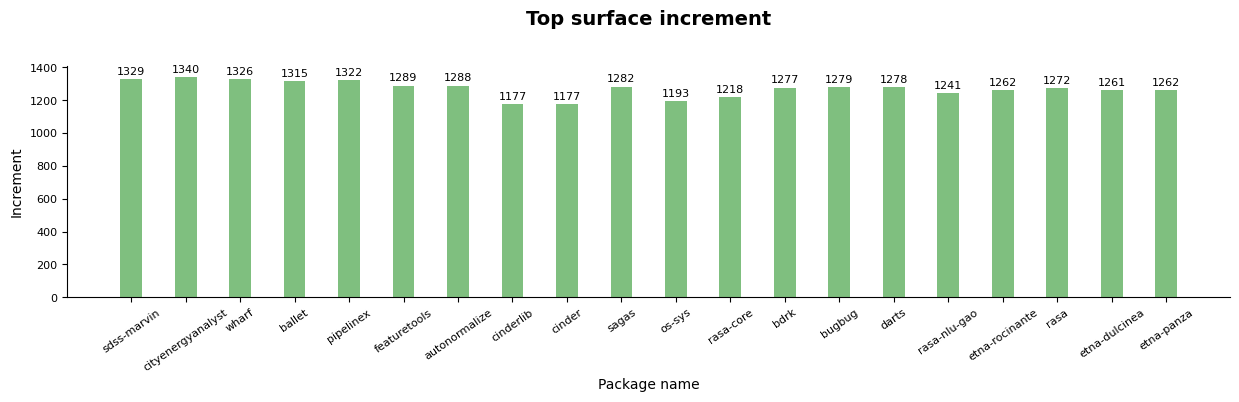

In [ ]:
# Plot surface increment
plt.figure(figsize=(15, 3))

increment = surface_df.head(20).astype(int)

plt.bar(
    increment.index,
    increment['increment'],
    color='green',
    width=0.4,
    alpha=0.5,
)

for i, v in zip(increment.index, increment['increment']):
    plt.text(i, v+30, f'{v}', color='black', ha='center', rotation=0, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.title('Top surface increment', fontsize=14, fontweight='bold', pad=30)

plt.xlabel('Package name')
plt.ylabel('Increment')
plt.xticks(rotation=35)
plt.show()


**Top surface decrease**

######

In [ ]:
# Decrease in surface
# -------------------

# Remove the rows with NaN values
surface_df = surface_df.dropna()
surface_df.tail(10)

librariesio  scraped  increment
pywwt                             66.0      1.0      -65.0
swifter                           66.0      1.0      -65.0
histomicsui                       72.0      5.0      -67.0
nova-lxd                          72.0      5.0      -67.0
airflow-aws-cost-explorer         75.0      2.0      -73.0
otree                             77.0      1.0      -76.0
rucio                             81.0      1.0      -80.0
starfish                          86.0      1.0      -85.0
kubeflow                          88.0      1.0      -87.0
localstack                        93.0      1.0      -92.0

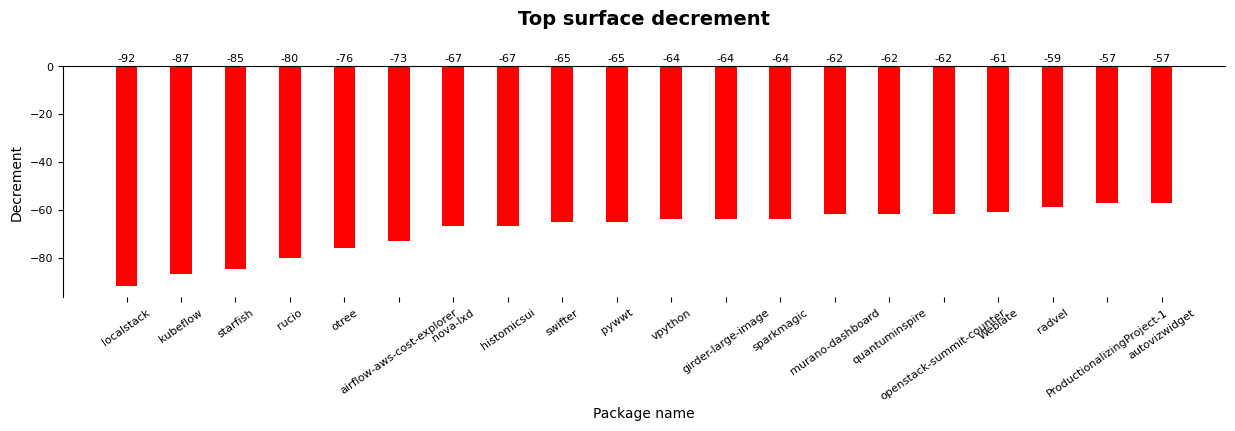

In [ ]:
# Plot surface decrement
plt.figure(figsize=(15, 3))

decrement = surface_df.tail(20).astype(int)

decrement.sort_values(by='increment', ascending=True, inplace=True)

plt.bar(
    decrement.index,
    decrement['increment'],
    color='red',
    width=0.4,
)

for i, v in zip(decrement.index, decrement['increment']):
    plt.text(i, 2, f'{v}', color='black', ha='center', rotation=0, fontsize=8)

# Adjusting plot borders
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.title('Top surface decrement', fontsize=14, fontweight='bold', pad=30)

plt.xlabel('Package name')

plt.ylabel('Decrement')
plt.xticks(rotation=35)
plt.show()


**Evolution**

######

Package ftw.subsite not found in scraped model
Package ftw.book not found in scraped model


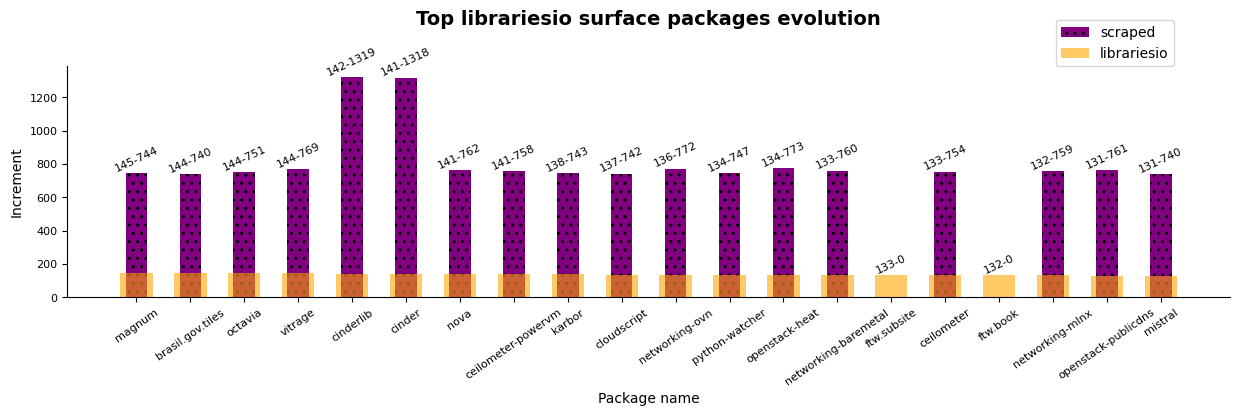

In [151]:
# Evolution of the top librariesio surface packages
# ------------------------------------------------

# order surface by librariesio value
surface_df.sort_values(by='librariesio', ascending=False, inplace=True)
top_surface_librariesio = dict(surface_df.head(20)['librariesio'])

# Get the surface of the top librariesio packages for scraped model
top_surface_scraped = {}
for package in top_surface_librariesio.keys():
    try:
        top_surface_scraped[package] = scraped_surface.results_dict[package]
    except KeyError:
        print(f'Package {package} not found in scraped model')
        top_surface_scraped[package] = 0

# Plot the evolution of the top librariesio surface packages
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in top_surface_scraped.items()],
    [x[1] for x in top_surface_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_surface_librariesio.items()],
    [x[1] for x in top_surface_librariesio.items()],

    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.6,
)

for i, v, v2 in zip([x[0] for x in top_surface_librariesio.items()], [x[1] for x in top_surface_librariesio.items()], [x[1] for x in top_surface_scraped.items()]):
    plt.text(i, max(v,v2)+10, f'{int(v)}-{v2}', color='black', ha='center', rotation=25, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.title('Top librariesio surface packages evolution', fontsize=14, fontweight='bold', pad=30)

plt.xlabel('Package name')
plt.ylabel('Increment')
plt.xticks(rotation=35)
plt.legend(loc=(0.85,1))
plt.show()


Package tifascore not found in librariesio model
Package adaseq not found in librariesio model
Package modelscope not found in librariesio model
Package geospatial-ml not found in librariesio model
Package NLP-Cryptography not found in librariesio model
Package synthcity not found in librariesio model
Package marvin not found in librariesio model
Package ai-python not found in librariesio model
Package napari-chatgpt not found in librariesio model
Package pychatgpt-gui not found in librariesio model
Package ontorunner not found in librariesio model
Package openbb-nightly not found in librariesio model
Package openbb not found in librariesio model
Package langsearch not found in librariesio model
Package skt not found in librariesio model
Package skm-tea not found in librariesio model
Package dmol-book not found in librariesio model
Package summertime not found in librariesio model
Package datascienv not found in librariesio model


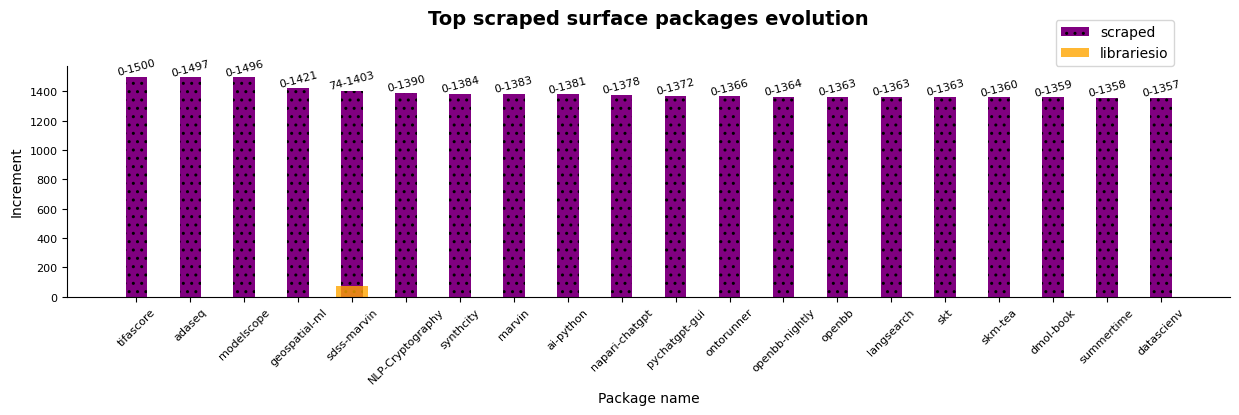

In [153]:
# Evolution of the top scraped surface packages
# ---------------------------------------------

# order surface by scraped value
surface_df.sort_values(by='scraped', ascending=False, inplace=True)
top_surface_scraped = dict(surface_df.head(20)['scraped'])

# Get the surface of the top scraped packages for librariesio model
top_surface_librariesio = {}
for package in top_surface_scraped.keys():
    try:
        top_surface_librariesio[package] = librariesio_surface.results_dict[package]
    except KeyError:
        print(f'Package {package} not found in librariesio model')
        top_surface_librariesio[package] = 0

# Plot the evolution of the top scraped surface packages
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in top_surface_scraped.items()],
    [x[1] for x in top_surface_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_surface_librariesio.items()],
    [x[1] for x in top_surface_librariesio.items()],
    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.8,
)

for i, v, v2 in zip([x[0] for x in top_surface_scraped.items()], [x[1] for x in top_surface_scraped.items()], [x[1] for x in top_surface_librariesio.items()]):
    plt.text(i, max(v,v2)+10, f'{int(v2)}-{int(v)}', color='black', ha='center', rotation=15, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.title('Top scraped surface packages evolution', fontsize=14, fontweight='bold', pad=30)

plt.xlabel('Package name')
plt.ylabel('Increment')
plt.xticks(rotation=45)
plt.legend(loc=(0.85,1))
plt.show()


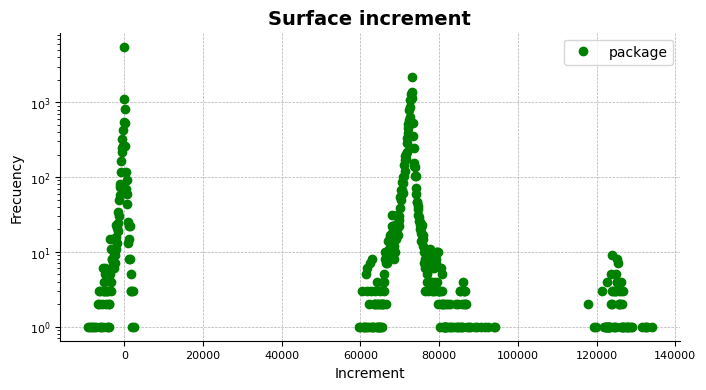

In [202]:
# Surface variation
# ---------------

surface_increase = list(surface_df['increment'].dropna())
surface_increase.sort(reverse=True)

# Plot impact increase
plt.figure(figsize=(8, 4))

# agrupar em intervalos de 100
surface_increase = [int(x / 1) * 100 for x in surface_increase]
x, y = zip(*Counter(surface_increase).items())

plt.plot(x, y, color='green', marker='o', linestyle='None', label='package')



plt.title('Surface increment', fontsize=14, fontweight='bold')

# Adjusting plot borders

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.xlabel('Increment')
plt.ylabel('Frecuency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('linear')
plt.yscale('log')
plt.show()

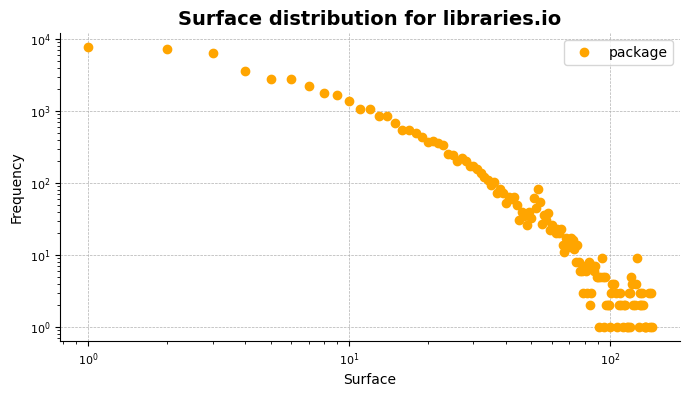

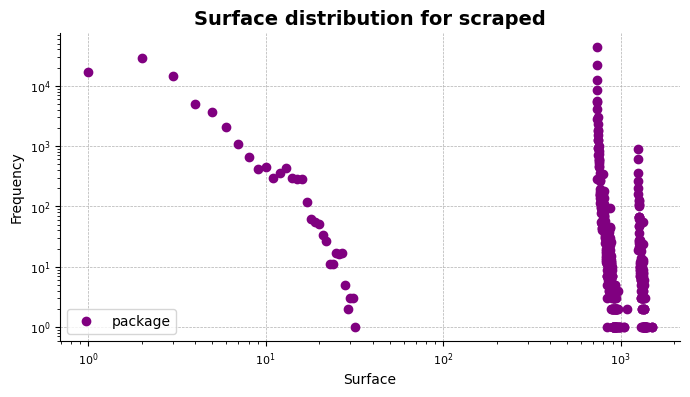

In [211]:
# Surface distribution for libraries.io
# -------------------------------------

# Plot Surface distribution
plt.figure(figsize=(8, 4))
surface = list(surface_df['librariesio'].dropna())
x, y = zip(*Counter(surface).items())
plt.plot(x, y, color='orange', marker='o', linestyle='None', label='package')
plt.title('Surface distribution for libraries.io', fontsize=14, fontweight='bold')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.xlabel('Surface')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()

# Surface distribution for scraped
# --------------------------------

# Plot Surface distribution
plt.figure(figsize=(8, 4))
surface = list(surface_df['scraped'].dropna())
x, y = zip(*Counter(surface).items())
plt.plot(x, y, color='purple', marker='o', linestyle='None', label='package')
plt.title('Surface distribution for scraped', fontsize=14, fontweight='bold')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.xlabel('Surface')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()

#### Dependencies

In [159]:
from olivia.packagemetrics import DependenciesCount

librariesio_dependencies = librariesio_model.get_metric(DependenciesCount)
scraped_dependencies = scraped_model.get_metric(DependenciesCount)

Computing Dependencies Count
Computing Dependencies Count


**Top dependencies**

###### 

In [160]:
# Top 10 dependencies count
# ----------------

top10_librariesio_dependencies_count = librariesio_dependencies.top(10)
top10_scraped_dependencies_count = scraped_dependencies.top(10)

# Top 10 dependencies count comparison
top10_dependencies_count_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_dependencies_count,
        'scraped': top10_scraped_dependencies_count,
    }
)
top10_dependencies_count_df

librariesio                       scraped
0  (cloudscript, 120)              (ai-python, 358)
1    (c7n-azure, 105)       (NLP-Cryptography, 352)
2   (TEStribute, 102)                (ivystar, 265)
3      (nucypher, 96)  (animal-classification, 230)
4     (azure-cli, 72)               (bitfount, 218)
5        (cateye, 72)            (luisito1996, 211)
6   (mycloud-cli, 71)           (luisito19963, 210)
7     (cloudview, 69)               (luis1996, 208)
8          (nova, 68)             (omdenalore, 206)
9  (ML-Navigator, 68)           (trialtracker, 200)

**Bottom dependencies**

###### 

In [161]:
# Top 10 less dependencies count
# ----------------

top10_librariesio_dependencies_count = librariesio_dependencies.bottom(10)
top10_scraped_dependencies_count = librariesio_dependencies.bottom(10)

# Top 10 dependencies count comparison
top10_dependencies_count_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_dependencies_count,
        'scraped': top10_scraped_dependencies_count,
    }
)
top10_dependencies_count_df

librariesio            scraped
0   (quaternions, 0)   (quaternions, 0)
1   (opencvutils, 0)   (opencvutils, 0)
2   (build-utils, 0)   (build-utils, 0)
3          (pydc, 0)          (pydc, 0)
4         (pydnx, 0)         (pydnx, 0)
5  (wcpan.logger, 0)  (wcpan.logger, 0)
6        (pfmisc, 0)        (pfmisc, 0)
7        (pprint, 0)        (pprint, 0)
8      (assertpy, 0)      (assertpy, 0)
9   (unit_system, 0)   (unit_system, 0)

**Top dependencies increment**

###### 

In [162]:
# Dataframe with the differences between the two models
librariesio_dependencies_count_df = pd.DataFrame(librariesio_dependencies.results_dict, index=['librariesio']).T
scraped_dependencies_count_df = pd.DataFrame(scraped_dependencies.results_dict, index=['scraped']).T

dependencies_count_df = pd.concat([librariesio_dependencies_count_df, scraped_dependencies_count_df], axis=1)
dependencies_count_df['increment'] = dependencies_count_df['scraped'] - dependencies_count_df['librariesio']
dependencies_count_df.sort_values(by='increment', ascending=False, inplace=True)
dependencies_count_df.head(10)

librariesio  scraped  increment
apache-airflow          41.0    185.0      144.0
sentry                  23.0    115.0       92.0
raiden                   0.0     88.0       88.0
crossbar                10.0     89.0       79.0
pyswarms                 2.0     78.0       76.0
rasa                     1.0     68.0       67.0
XTCryptoSignals         20.0     84.0       64.0
seleniumbase            17.0     79.0       62.0
c7n-mailer              11.0     69.0       58.0
panel                    5.0     63.0       58.0

**Top dependencies decrement**

###### 

In [163]:
# Decrease in dependencies count
# -------------------

# Remove the rows with NaN values
dependencies_count_df = dependencies_count_df.dropna()
dependencies_count_df.tail(10)

librariesio  scraped  increment
the-whole-caboodle          43.0      5.0      -38.0
koku-nise                   46.0      8.0      -38.0
zbuilder                    60.0     21.0      -39.0
horizon                     61.0     21.0      -40.0
edx-enterprise-data         60.0     17.0      -43.0
c7n-azure                  105.0     47.0      -58.0
otree                       58.0      0.0      -58.0
rucio                       60.0      0.0      -60.0
cateye                      72.0      2.0      -70.0
cloudscript                120.0     36.0      -84.0

**Evolution**

###### 

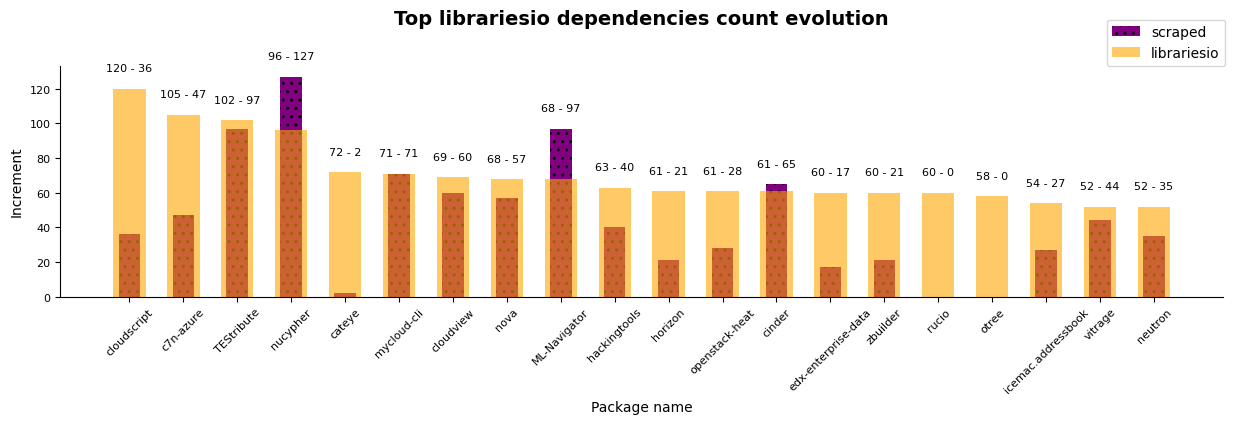

In [177]:
# Plot the evolution of the top librariesio

# order dependencies by librariesio value
dependencies_count_df.sort_values(by='librariesio', ascending=False, inplace=True)
dependencies_count_librariesio = dict(dependencies_count_df.head(20)['librariesio'])

# Get the dependencies of the top scraped packages for librariesio model
top_dependencies_count_scraped = {}
for package in dependencies_count_librariesio.keys():
    try:
        top_dependencies_count_scraped[package] = scraped_dependencies.results_dict[package]
    except KeyError:
        top_dependencies_count_scraped[package] = 0

# Plot the evolution of the top scraped
plt.figure(figsize=(15, 3))


plt.bar(
    [x[0] for x in top_dependencies_count_scraped.items()],
    [x[1] for x in top_dependencies_count_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in dependencies_count_librariesio.items()],
    [x[1] for x in dependencies_count_librariesio.items()],
    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.6,
)


for i, v in enumerate(top_dependencies_count_scraped.values()):
    v2 = dependencies_count_librariesio[list(top_dependencies_count_scraped.keys())[i]]
    plt.text(i, max(v,v2)+10, f'{int(v2)} - {int(v)}', color='black', ha='center', rotation=0, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.title('Top librariesio dependencies count evolution', fontsize=14, fontweight='bold', pad=30)

plt.xlabel('Package name')
plt.ylabel('Increment')
plt.xticks(rotation=45)
plt.legend(loc=(0.9,1))
plt.show()

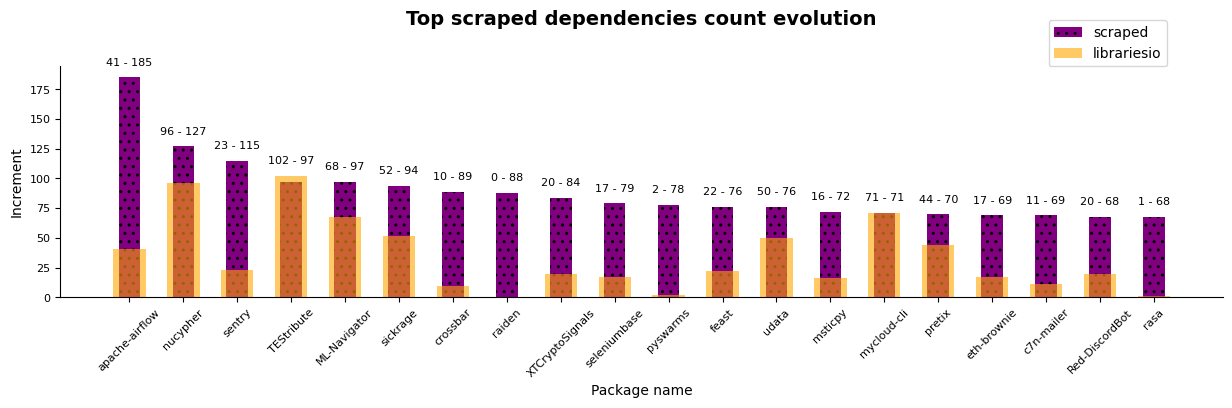

In [182]:
# Plot the evolution of the top scraped 

# order dependencies by scraped value
dependencies_count_df.sort_values(by='scraped', ascending=False, inplace=True)
dependencies_count_scraped = dict(dependencies_count_df.head(20)['scraped'])

# Get the dependencies of the top librariesio packages for scraped model
top_dependencies_count_librariesio = {}
for package in dependencies_count_scraped.keys():
    try:
        top_dependencies_count_librariesio[package] = librariesio_dependencies.results_dict[package]
    except KeyError:
        top_dependencies_count_librariesio[package] = 0

# Plot the evolution of the top scraped
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in dependencies_count_scraped.items()],
    [x[1] for x in dependencies_count_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_dependencies_count_librariesio.items()],
    [x[1] for x in top_dependencies_count_librariesio.items()],
    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.6,
)


for i, v in enumerate(top_dependencies_count_librariesio.values()):
    v2 = dependencies_count_scraped[list(top_dependencies_count_librariesio.keys())[i]]
    plt.text(i, max(v,v2)+10, f'{int(v)} - {int(v2)}', color='black', ha='center', rotation=0, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.title('Top scraped dependencies count evolution', fontsize=14, fontweight='bold', pad=30)

plt.xlabel('Package name')
plt.ylabel('Increment')
plt.xticks(rotation=45)

plt.legend(loc=(0.85,1))
plt.show()

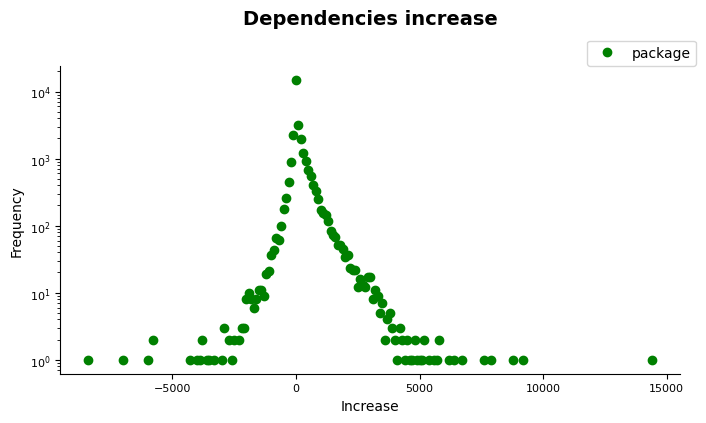

In [191]:
# Dependencies variation
# --------------------------------

dependencies_increase = list(dependencies_count_df['increment'].dropna())
dependencies_increase.sort(reverse=True)

# Plot impact increase
plt.figure(figsize=(8, 4))

# agrupar em intervalos de 100
dependencies_increase = [int(x / 1) * 100 for x in dependencies_increase]
x, y = zip(*Counter(dependencies_increase).items())

plt.plot(x, y, color='green', marker='o', linestyle='None', label='package')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)

plt.title('Dependencies increase', fontsize=14, fontweight='bold', pad=30)
plt.ylabel('Frequency')
plt.xlabel('Increase')
plt.xscale('linear')
plt.yscale('log')
plt.legend(loc=(0.85,1))
plt.show()






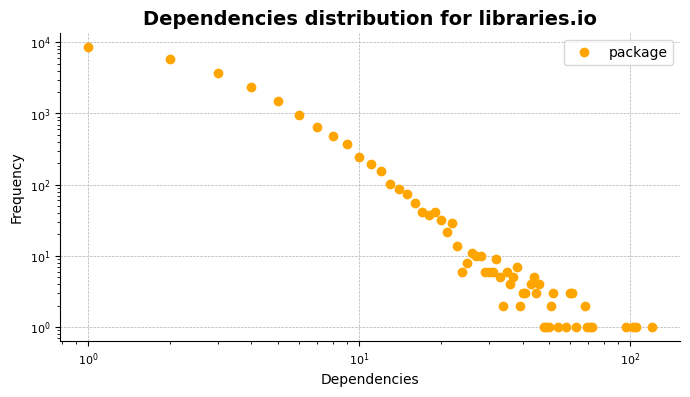

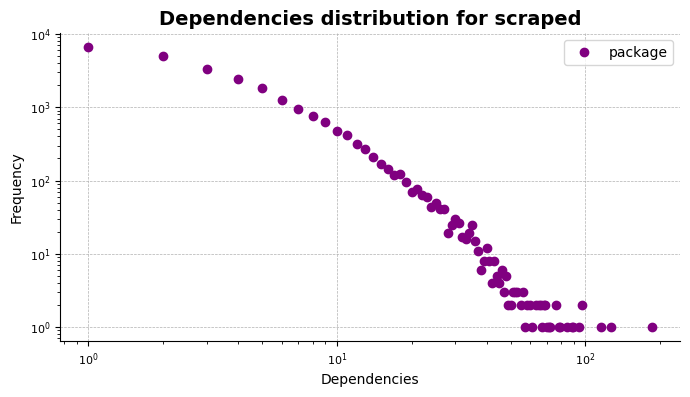

In [213]:
# Dependencies count distribution for librariesio model
# --------------------------------

# Plot dependencies count distribution
plt.figure(figsize=(8, 4))
dependencies = list(dependencies_count_df['librariesio'].dropna())
x, y = zip(*Counter(dependencies).items())
plt.plot(x, y, color='orange', marker='o', linestyle='None', label='package')
plt.title('Dependencies distribution for libraries.io', fontsize=14, fontweight='bold')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.xlabel('Dependencies')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()

# Dependencies count distribution for scraped model
# --------------------------------

# Plot dependencies count distribution
plt.figure(figsize=(8, 4))

dependencies = list(dependencies_count_df['scraped'].dropna())
x, y = zip(*Counter(dependencies).items())
plt.plot(x, y, color='purple', marker='o', linestyle='None', label='package')
plt.title('Dependencies distribution for scraped', fontsize=14, fontweight='bold')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.xlabel('Dependencies')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()


#### Dependents

In [215]:
from olivia.packagemetrics import DependentsCount

librariesio_dependents = librariesio_model.get_metric(DependentsCount)
scraped_dependents = scraped_model.get_metric(DependentsCount)

Computing Dependents Count
Computing Dependents Count


In [216]:
# Top 10 dependents count
# ----------------

top10_librariesio_dependents_count = librariesio_dependents.top(10)
top10_scraped_dependents_count = scraped_dependents.top(10)

# Top 10 dependents count comparison
top10_dependents_count_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_dependents_count,
        'scraped': top10_scraped_dependents_count,
    }
)
top10_dependents_count_df

librariesio              scraped
0        (requests, 10156)       (numpy, 39295)
1              (six, 4451)    (requests, 37816)
2            (numpy, 3773)      (pandas, 25584)
3            (click, 2403)      (pytest, 24354)
4       (setuptools, 1921)  (matplotlib, 16979)
5  (python-dateutil, 1735)       (scipy, 15892)
6           (pyyaml, 1656)      (python, 15668)
7           (PyYAML, 1390)        (odoo, 13794)
8             (lxml, 1215)       (click, 12657)
9           (pandas, 1129)        (tqdm, 10382)

In [217]:
# Top 10 less dependents count
# ----------------------------

top10_librariesio_dependents_count = librariesio_dependents.bottom(10)
top10_scraped_dependents_count = scraped_dependents.bottom(10)

# Top 10 dependents count comparison
top10_dependents_count_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_dependents_count,
        'scraped': top10_scraped_dependents_count,
    }
)

top10_dependents_count_df

librariesio                                     scraped
0           (djangoadmin, 0)                              (yt-xarray, 0)
1         (djangoarticle, 0)                     (botbuilder-dialogs, 0)
2             (elasticdl, 0)                            (async-slack, 0)
3            (djangopost, 0)                                (arabert, 0)
4            (mpy-editor, 0)                  (ansys-ace-project-gen, 0)
5              (storeimg, 0)            (abstract-telegram-processor, 0)
6      (coopstarter-data, 0)  (odoo8-addon-stock-packaging-usability, 0)
7  (tesseract-positional, 0)                             (xpartition, 0)
8               (readlif, 0)                        (xarray-ome-ngff, 0)
9               (nsq-api, 0)                               (pyfigure, 0)

In [218]:
# Dataframe with the differences between the two models
librariesio_dependents_count_df = pd.DataFrame(librariesio_dependents.results_dict, index=['librariesio']).T
scraped_dependents_count_df = pd.DataFrame(scraped_dependents.results_dict, index=['scraped']).T

dependents_count_df = pd.concat([librariesio_dependents_count_df, scraped_dependents_count_df], axis=1)
dependents_count_df['difference'] = dependents_count_df['scraped'] - dependents_count_df['librariesio']
dependents_count_df.sort_values(by='difference', ascending=False, inplace=True)
dependents_count_df.head(10)

librariesio  scraped  difference
numpy            3773.0  39295.0     35522.0
requests        10156.0  37816.0     27660.0
pandas           1129.0  25584.0     24455.0
pytest            900.0  24354.0     23454.0
matplotlib        658.0  16979.0     16321.0
scipy             738.0  15892.0     15154.0
click            2403.0  12657.0     10254.0
tqdm              795.0  10382.0      9587.0
sphinx            219.0   8664.0      8445.0
flake8            165.0   8004.0      7839.0

In [220]:
# Decrease in dependents count
# -------------------

# Remove the rows with NaN values
dependents_count_df = dependents_count_df.dropna()
dependents_count_df['difference'] = dependents_count_df['difference'].abs()
dependents_count_df.tail(10)

librariesio  scraped  difference
public                          158.0     11.0       147.0
oslo.utils                      153.0      0.0       153.0
aws-cdk.core                    153.0      0.0       153.0
Adafruit-Blinka                 154.0      0.0       154.0
python-dotenv                   176.0      0.0       176.0
requests-toolbelt               178.0      0.0       178.0
websocket-client                217.0      0.0       217.0
scikit-learn                    217.0      0.0       217.0
google-api-python-client        220.0      0.0       220.0
python-dateutil                1735.0      0.0      1735.0

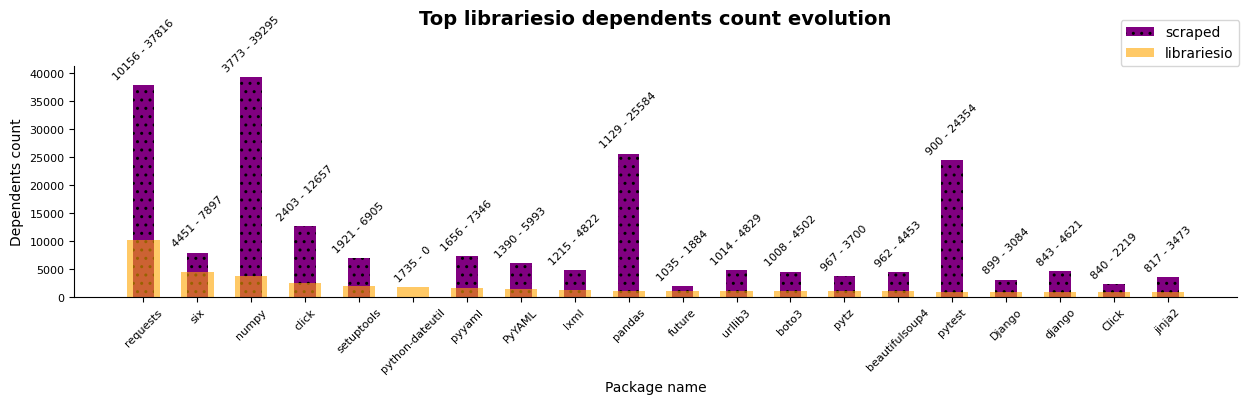

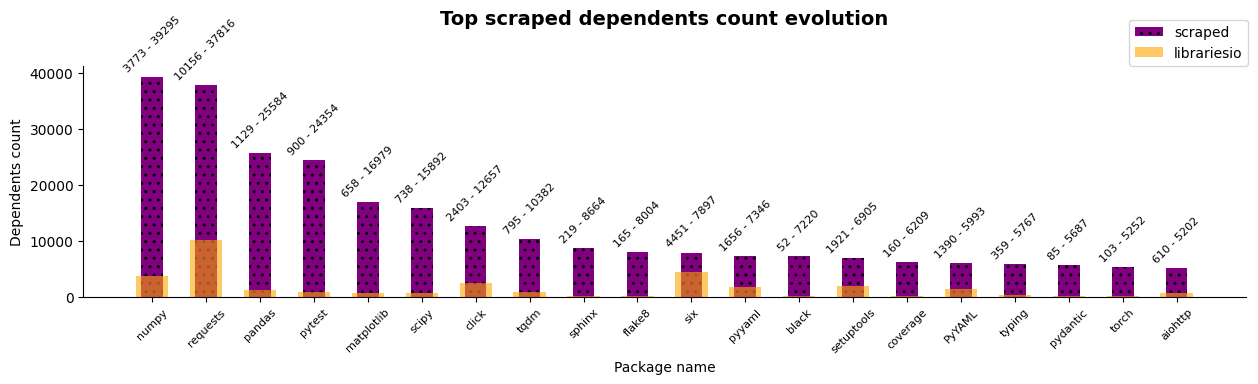

In [236]:
# Plot the evolution of the top librariesio

# order dependencies by librariesio value
dependents_count_df.sort_values(by='librariesio', ascending=False, inplace=True)
dependents_count_librariesio = dict(dependents_count_df.head(20)['librariesio'])

# Get the dependencies of the top scraped packages for librariesio model
top_dependents_count_scraped = {}
for package in dependents_count_librariesio.keys():
    try:
        top_dependents_count_scraped[package] = scraped_dependents.results_dict[package]
    except KeyError:
        top_dependents_count_scraped[package] = 0

# Plot the evolution of the top scraped
plt.figure(figsize=(15, 3))


plt.bar(
    [x[0] for x in top_dependents_count_scraped.items()],
    [x[1] for x in top_dependents_count_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in dependents_count_librariesio.items()],
    [x[1] for x in dependents_count_librariesio.items()],
    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.6,
)


for i, v in enumerate(top_dependents_count_scraped.values()):
    v2 = dependents_count_librariesio[list(top_dependents_count_scraped.keys())[i]]
    plt.text(i, max(v,v2)+1000, f'{int(v2)} - {int(v)}', color='black', ha='center', rotation=45, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.title('Top librariesio dependents count evolution', fontsize=14, fontweight='bold', pad=30)

plt.xlabel('Package name')
plt.ylabel('Dependents count')
plt.xticks(rotation=45)
plt.legend(loc=(0.9,1))
plt.show()


# Plot the evolution of the top scraped
plt.figure(figsize=(15, 3))

# order dependencies by scraped value
dependents_count_df.sort_values(by='scraped', ascending=False, inplace=True)
dependents_count_scraped = dict(dependents_count_df.head(20)['scraped'])

top_dependents_count_librariesio = {}
for package in dependents_count_scraped.keys():
    try:
        top_dependents_count_librariesio[package] = librariesio_dependents.results_dict[package]
    except KeyError:
        top_dependents_count_librariesio[package] = 0



plt.bar(
    [x[0] for x in dependents_count_scraped.items()],
    [x[1] for x in dependents_count_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_dependents_count_librariesio.items()],
    [x[1] for x in top_dependents_count_librariesio.items()],
    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.6,

)

for i, v in enumerate(top_dependents_count_librariesio.values()):
    v2 = dependents_count_scraped[list(top_dependents_count_librariesio.keys())[i]]
    plt.text(i, max(v,v2)+1000, f'{int(v)} - {int(v2)}', color='black', ha='center', rotation=45, fontsize=8)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.title('Top scraped dependents count evolution', fontsize=14, fontweight='bold', pad=30)
plt.xlabel('Package name')
plt.ylabel('Dependents count')
plt.xticks(rotation=45)
plt.legend(loc=(0.9,1))
plt.show()


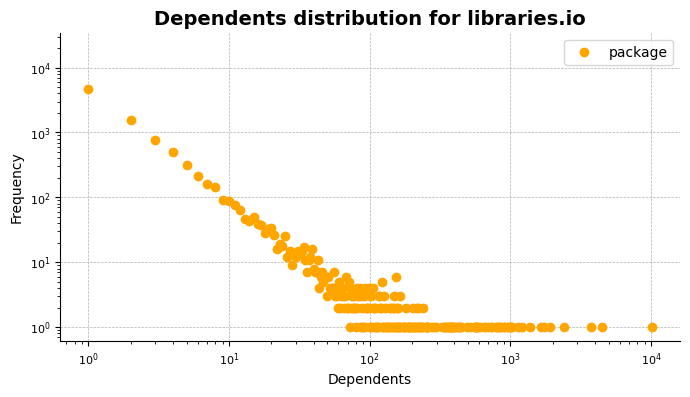

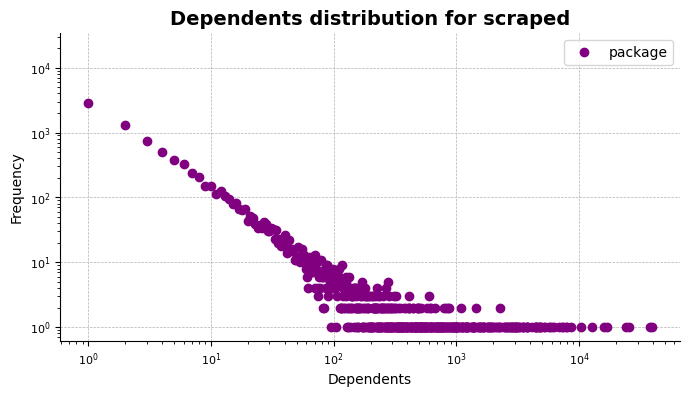

In [238]:
# Libriesio dependents distribution
# -------------------

plt.figure(figsize=(8, 4))
dependents = list(dependents_count_df['librariesio'].dropna())
x, y = zip(*Counter(dependents).items())
plt.plot(x, y, color='orange', marker='o', linestyle='None', label='package')
plt.title('Dependents distribution for libraries.io', fontsize=14, fontweight='bold')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.xlabel('Dependents')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()


plt.figure(figsize=(8, 4))
dependents = list(dependents_count_df['scraped'].dropna())
x, y = zip(*Counter(dependents).items())
plt.plot(x, y, color='purple', marker='o', linestyle='None', label='package')
plt.title('Dependents distribution for scraped', fontsize=14, fontweight='bold')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=8)
plt.gca().tick_params(axis='y', labelsize=8)
plt.xlabel('Dependents')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()

## 3 - Visualization of the network

To visualize a portion of the network, we will process the nodes to remove some of them and achieve a cleaner visualization.

#### Example 0: **Minimized network**

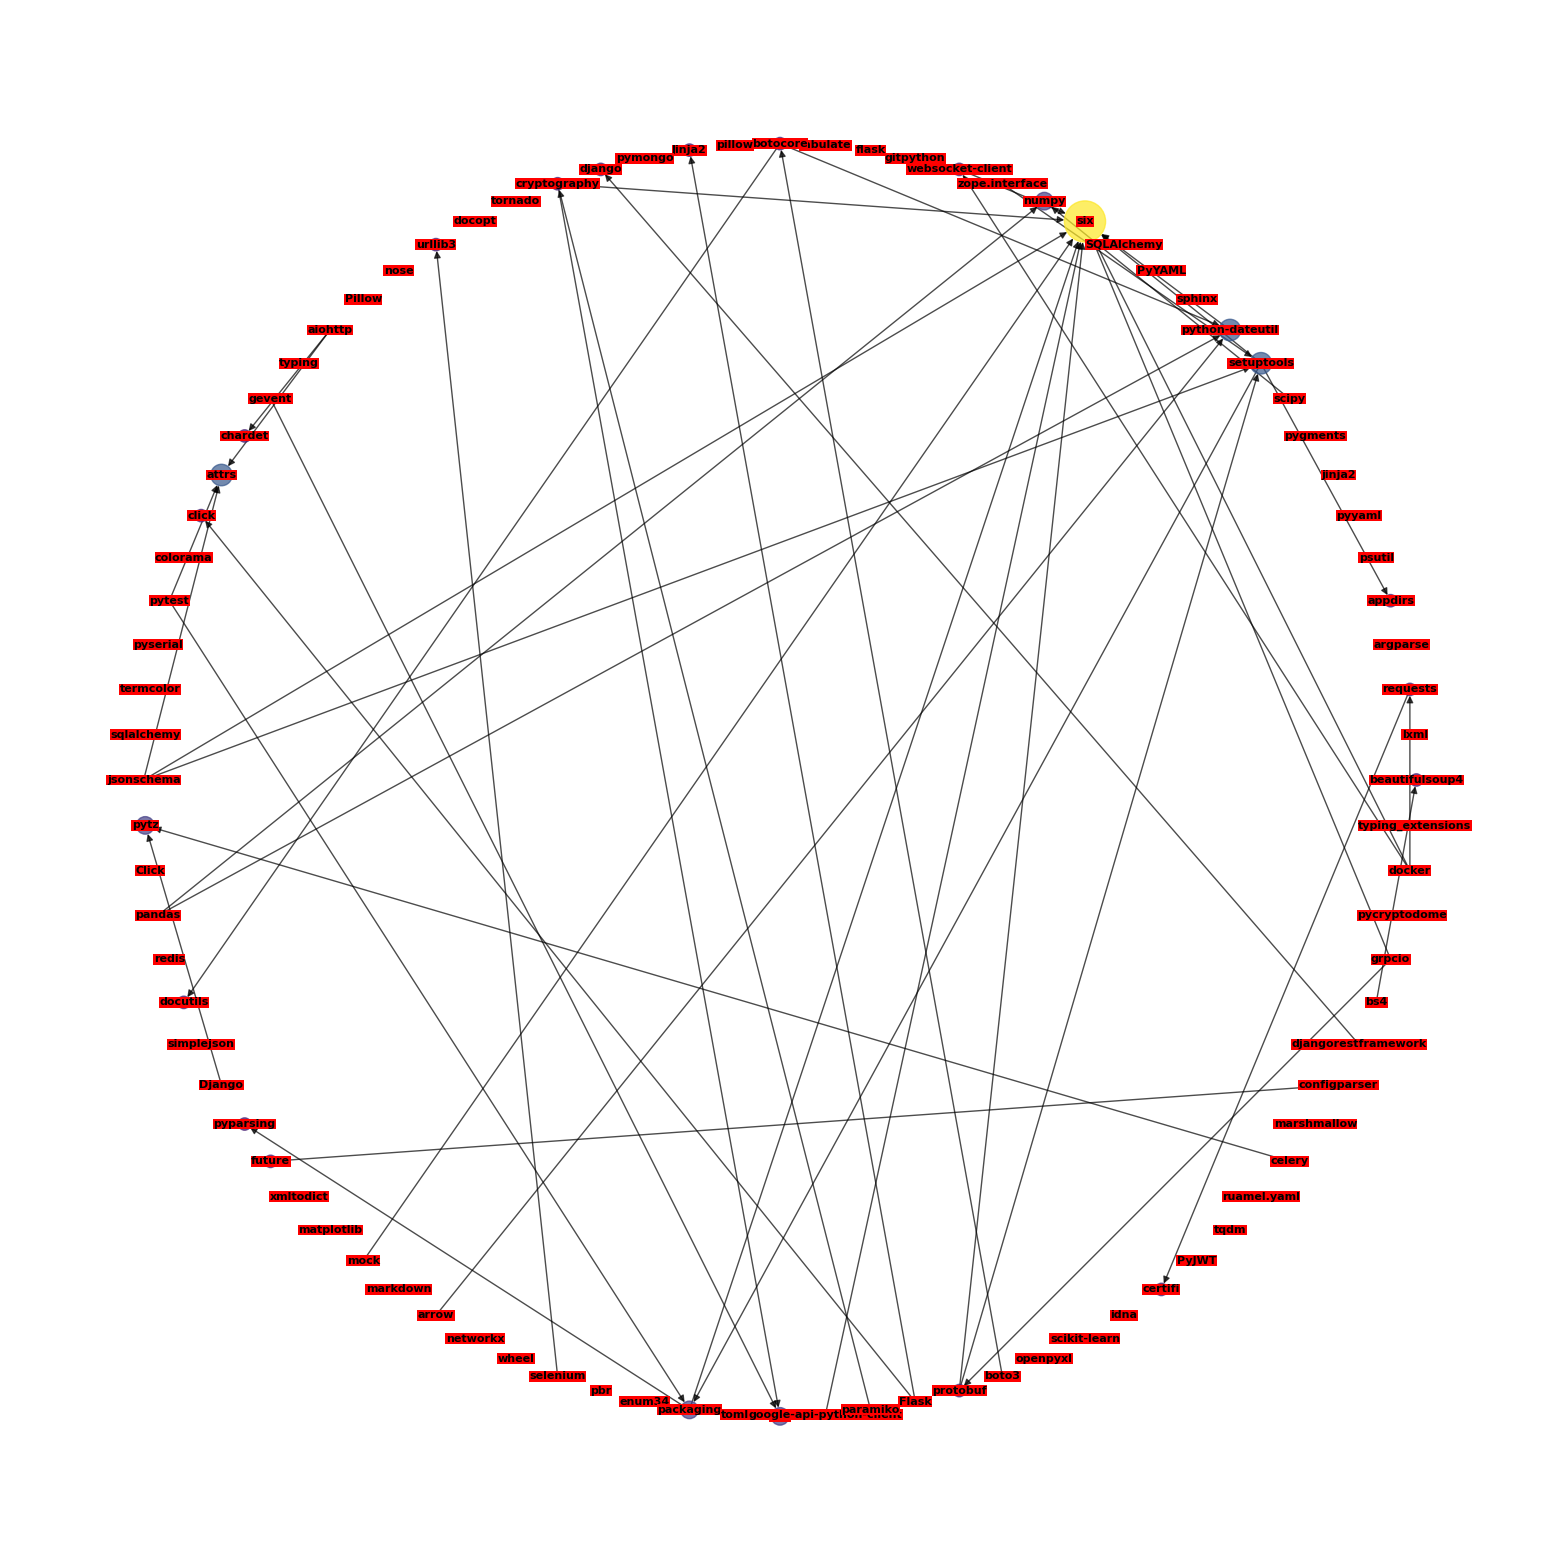

In [ ]:
# Remove nodes with degree < 100
filtered_librariesio_G = librariesio_G.copy()
filtered_librariesio_G.remove_nodes_from([node for node, degree in librariesio_G.degree() if degree < 200])

# Draw libraries.io graph
draw_networkx_graph(filtered_librariesio_G, layout='circular', size=(20,20))

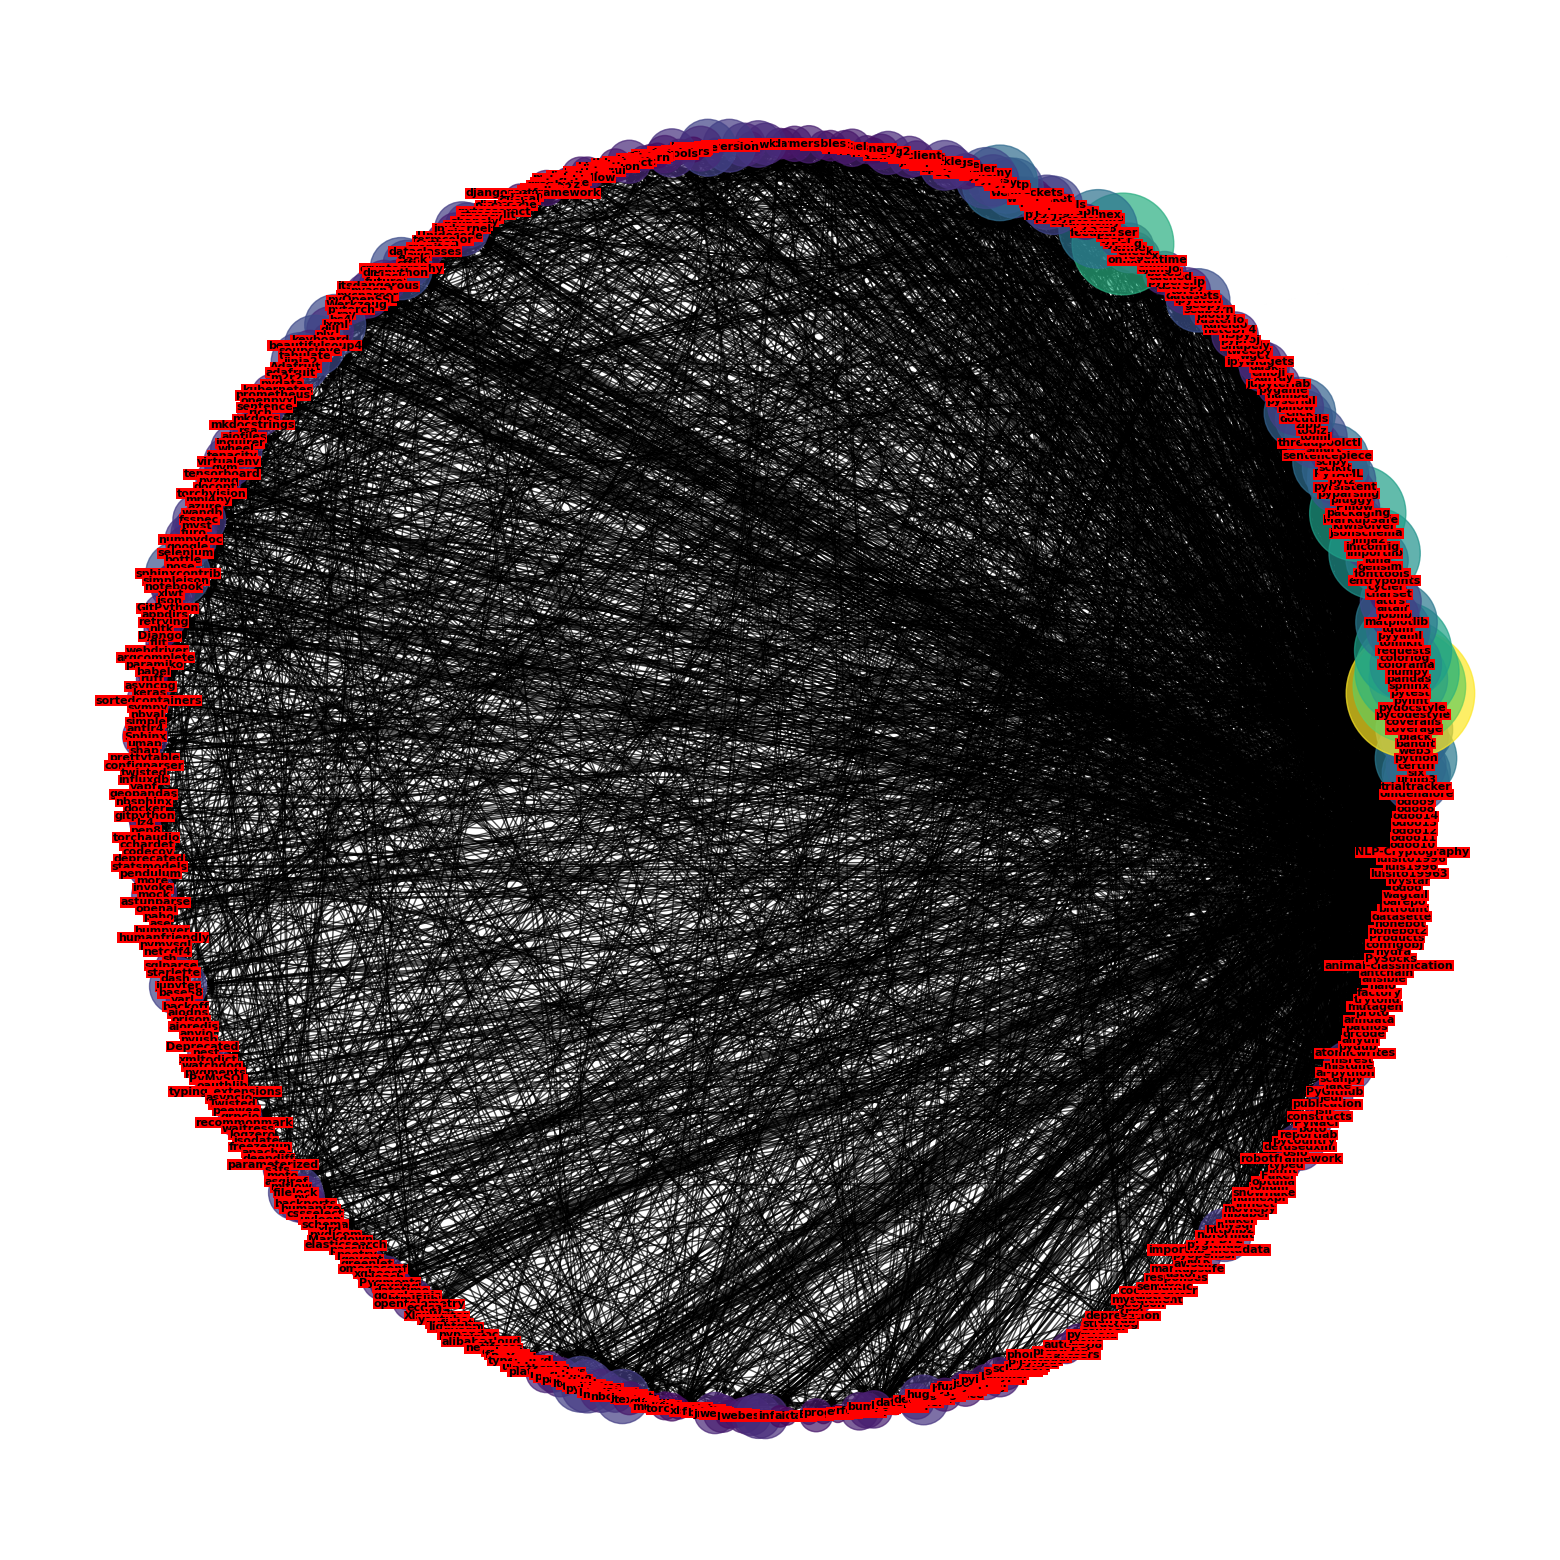

In [ ]:
# scraped graph
filtered_scraped_G = scraped_G.copy()
filtered_scraped_G.remove_nodes_from([node for node, degree in scraped_G.degree() if degree < 200])

# Draw scraped graph
draw_networkx_graph(filtered_scraped_G, layout='circular', size=(20,20))

In [ ]:
# Comparing the two graphs statistics
m1 = calculate_metrics(filtered_librariesio_G)
m2 = calculate_metrics(filtered_scraped_G)

# concatenate the two metrics
metrics = pd.concat([m1, m2])
metrics.index = ['librariesio', 'scraped']
metrics

Number of nodes  Number of edges  Average clustering coefficient  \
librariesio               88               44                        0.021539   
scraped                  552             3875                        0.105522   

             Average degree  Average in degree  Average out degree  \
librariesio        1.000000           0.500000            0.500000   
scraped           14.039855           7.019928            7.019928   

             Number of isolated nodes  
librariesio                        43  
scraped                            48

We can visualize the underlying network for a single package (dependency network of that package) given a certain depth.

#### Example 1: **pandas network**

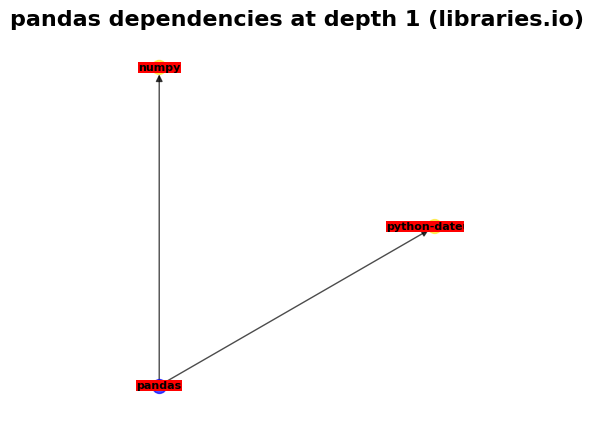

Number of nodes  Number of edges  Average clustering coefficient  \
0                3                2                             0.0   

   Average degree  Average in degree  Average out degree  \
0        1.333333           0.666667            0.666667   

   Number of isolated nodes  
0                         0

In [ ]:
libraries_pandas_G = draw_package_deep_network(
    librariesio_G, 'pandas', 1, size=(5, 5), layout='circular', title='pandas dependencies at depth 1 (libraries.io)'
)

m1 = calculate_metrics(libraries_pandas_G)
m1


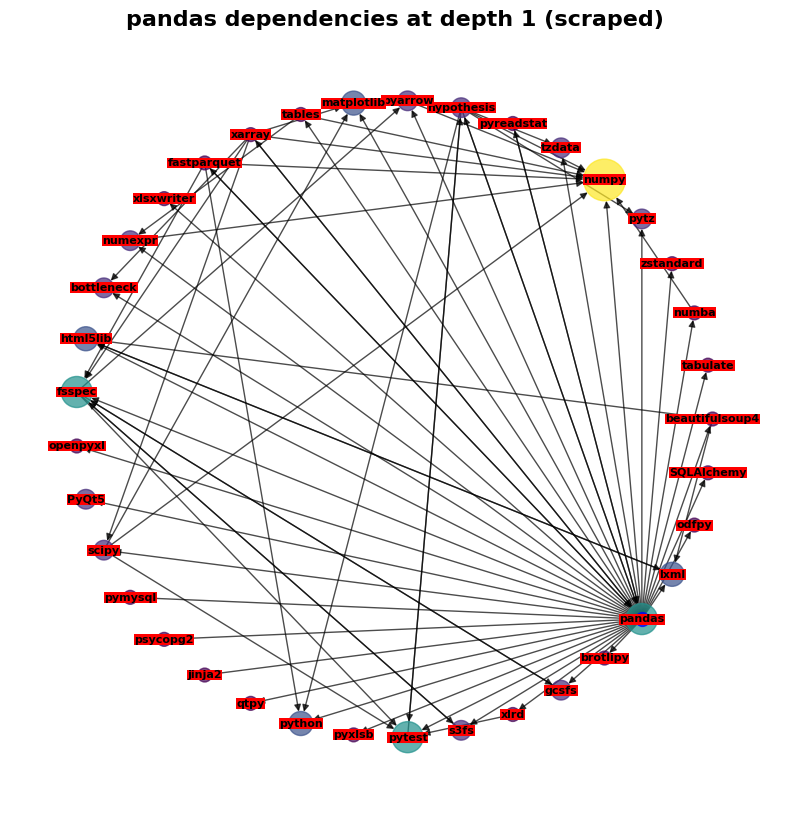

In [ ]:
scraped_pandas_G = draw_package_deep_network(scraped_G, 'pandas', 1, size=(10, 10), layout='circular', title='pandas dependencies at depth 1 (scraped)')
m2 = calculate_metrics(scraped_pandas_G)

In [ ]:
# Combine the metrics of both graphs
comparison = pd.concat([m1, m2], axis=0)
comparison.index = ['libraries.io', 'scraped']
comparison

Number of nodes  Number of edges  \
libraries.io                2                1   
scraped                    19               46   

              Average clustering coefficient  Average degree  \
libraries.io                        0.000000        1.000000   
scraped                             0.211197        4.842105   

              Average in degree  Average out degree  Number of isolated nodes  
libraries.io           0.500000            0.500000                         0  
scraped                2.421053            2.421053                         0

#### Example 2: **cateye networks**

We will represent the dependency network of the package "mixtools".

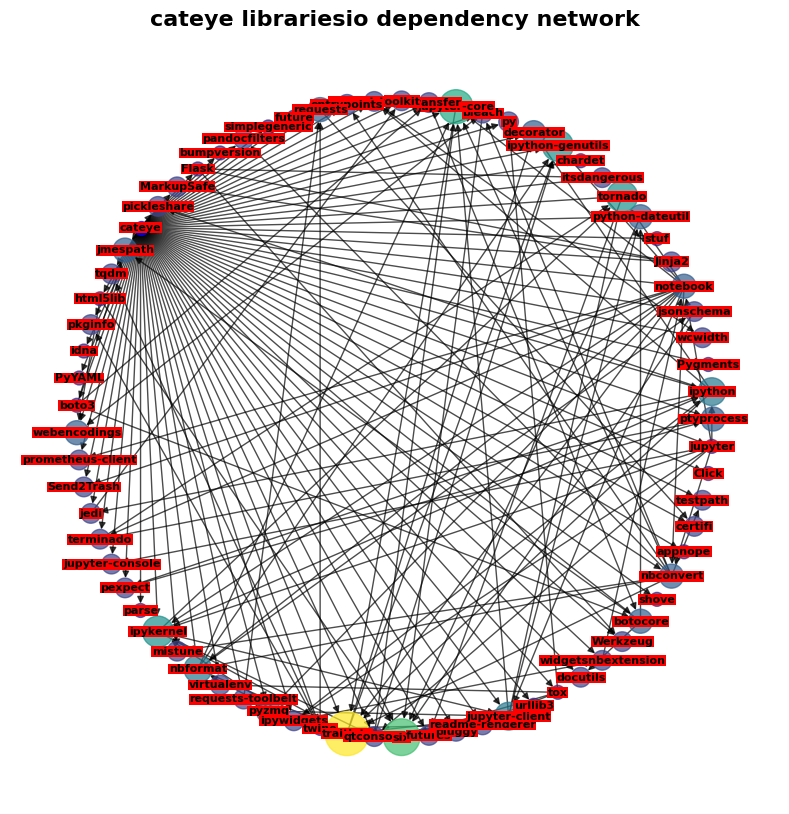

Number of nodes  Number of edges  Average clustering coefficient  \
0               73              167                         0.30927   

   Average degree  Average in degree  Average out degree  \
0        4.575342           2.287671            2.287671   

   Number of isolated nodes  
0                         0

In [ ]:
cateye_librariesio_G = draw_package_deep_network(librariesio_G, 'cateye', 1, size=(10, 10), layout='circular', title='cateye librariesio dependency network')
m1 = calculate_metrics(cateye_librariesio_G)
m1

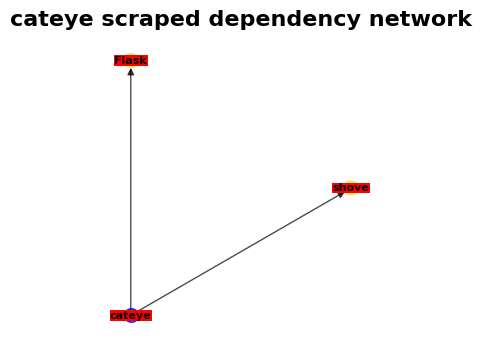

Number of nodes  Number of edges  Average clustering coefficient  \
0                3                2                             0.0   

   Average degree  Average in degree  Average out degree  \
0        1.333333           0.666667            0.666667   

   Number of isolated nodes  
0                         0

In [ ]:
cateye_scraped_G = draw_package_deep_network(scraped_G, 'cateye', 1, size=(4, 4), layout='circular', title='cateye scraped dependency network')
m2 = calculate_metrics(cateye_scraped_G)
m2

In [ ]:
# Combine the metrics of both graphs
comparison = pd.concat([m1, m2], axis=0)
comparison.index = ['libraries.io', 'scraped']
comparison

Number of nodes  Number of edges  \
libraries.io               73              167   
scraped                     3                2   

              Average clustering coefficient  Average degree  \
libraries.io                         0.30927        4.575342   
scraped                              0.00000        1.333333   

              Average in degree  Average out degree  Number of isolated nodes  
libraries.io           2.287671            2.287671                         0  
scraped                0.666667            0.666667                         0